# Topic Modeling VTB24

In [226]:
import pandas as pd
import tqdm
import regex
import os
import re
import shutil
import matplotlib.pyplot as plt
import artm
import codecs
from seaborn import heatmap
import time
from math import log
import operator
import numpy as np
from nltk import sent_tokenize
from pymystem3 import Mystem
from tools import *
import cPickle as pickle
from preprocess_line import CollocationSyntax, add_collocation, lemmatize
from create_ww_and_pmi_count import main as prepare_vw_wntm_pmi_vocab
%matplotlib inline

**Описание данных**:
* author ---  автор комментария
* bank --- название банка
* bank_response --- ответ банка на отзыв
* comment_page --- номера страницы с комментариями
* comments_n --- число комментариев к отзыву
* rating ---  оценка банку + статус
* text --- текс отзыва
* time --- время добавление отзыва
* title --- заголовок комментария

In [227]:
FOLDER_DATA = "vtb24/"
REPLIES = FOLDER_DATA + "replies.pkl"
SENTENCES_REPLIES = FOLDER_DATA + 'sentences_replies.pkl'
FOLDER_BATCHES = FOLDER_DATA + 'batches/'
BRANCHES = FOLDER_DATA + "branches.pkl"
COLLOCATIONS = FOLDER_DATA + "collocations.txt"

COLUMN_REPLY_ID = "reply_id"
COLUMN_VOCAB_ONLY = "vocab_only"
COLUMN_SENTENCE = "sentence"
COLUMN_DELETE_EXTRA_SYMBOLS = "deleted_extra_symbols"
COLUMN_LEMMATIZED = "lemmatized"
COLUMN_VOCAB_ONLY = "vocab_only"

SYNTAXNET_INPUT = FOLDER_DATA + "to_syntaxnet.txt"
SYNTAXNET_OUTPUT = FOLDER_DATA + "from_syntaxnet.txt"
SYNTAXNET_MODELS_PATH = "~/Python_libs/models/syntaxnet/syntaxnet"
SYNTAXNET_OUTPUT_PKL = FOLDER_DATA + "from_syntaxnet.pkl"

In [228]:
replies = pd.read_pickle(REPLIES)

In [298]:
sentences_replies = pd.read_pickle(SENTENCES_REPLIES)

In [301]:
branches = pd.read_pickle(BRANCHES)

In [231]:
replies.shape

(21572, 10)

In [232]:
sentences_replies.shape

(349657, 6)

In [233]:
branches.shape

(1613641, 3)

In [590]:
replies.head(2)

,author,bank,bank_response,comment_page,comments_n,rating,text,time,title,mark
43781,ne_podarok-88,vtb24,None,1,0,оценка: 1 проверяется,Добрый день! хочу поделиться своими впечатле...,07.04.2017 0:12,почему нельзя пойти на встречу???,1
43795,Iankovskii,vtb24,None,1,0,без оценки,Здравствуйте! 05.04.17 года я обратился по тел...,06.04.2017 20:48,Навязывают страховку,-1


In [589]:
sentences_replies.head(5)

,sentence,reply_id,deleted_extra_symbols,lemmatized,vocab_only,vw
634075,Добрый день!,43781,добрый день,добрый день,добрый день,"{u'день': 1, u'добрый': 1}"
634076,хочу поделиться своими впечатлениями от банка ...,43781,хочу поделиться своими впечатлениями от банка ...,хотеть поделиться свой впечатление от банк в ц...,хотеть поделиться свой впечатление от банк в ц...,"{u'банк': 1, u'поделиться': 1, u'впечатление_п..."
634077,"вообще, кредит я в ВТБ не брала, но... мой пот...",43781,вообще кредит я в втб не брала но мой потреб с...,вообще кредит я в втб не брать но мой потреба ...,вообще кредит я в втб не брать но мой потреба ...,"{u'брать': 18, u'вопрос': 1, u'туда': 1, u'кот..."
634078,"Соглашусь, не от большого ума, я тоже решила о...",43781,соглашусь не от большого ума я тоже решила отд...,соглашаться не от большой ум я тоже решать отд...,соглашаться не от большой ум я тоже решать отд...,"{u'виноватый': 1, u'заслуживать': 1, u'клиент'..."
634079,Через время со мной связался С... из службы вз...,43781,через время со мной связался с из службы взыск...,через время со я связываться с из служба взыск...,через время со я связываться с из служба взыск...,"{u'время': 1, u'история': 4, u'отвечать': 1, u..."


In [322]:
branches.head(5)

,sentence_id,branch_id,branch
2922121,634075,0,объяснять заша_л отдел кредитный
2922122,634075,1,объяснять там
2922123,634075,2,объяснять вс
2922124,634075,3,объяснять грамотно
2922125,634075,4,объяснять документ какой


In [235]:
numbers_str = [str(i) for i in xrange(300)]

In [236]:
replies.comments_n.value_counts()

1                                                                          5341
0                                                                          4479
2                                                                          3822
3                                                                          2494
4                                                                          1562
5                                                                          1089
6                                                                           729
7                                                                           473
8                                                                           352
9                                                                           265
10                                                                          194
11                                                                          151
12                                      

In [237]:
replies['comments_n'] = replies['comments_n'].map(lambda x: int(x) if x in numbers_str else 0)
replies.shape

(21572, 10)

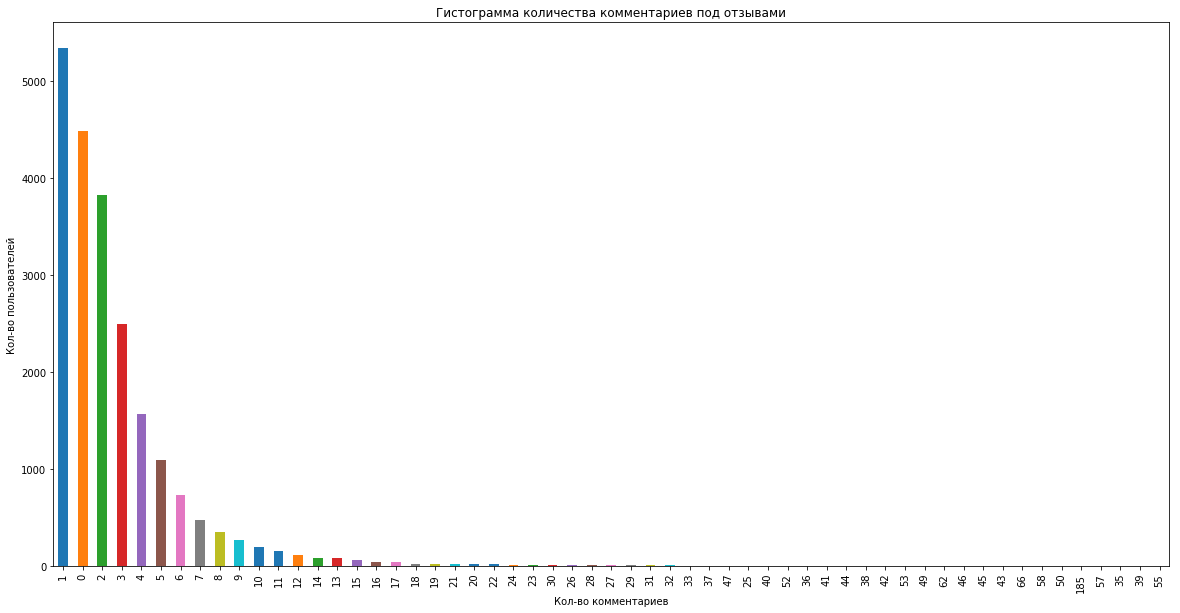

In [238]:
plt.figure(figsize=(20, 10))
plt.title(u"Гистограмма количества комментариев под отзывами")
plt.ylabel(u"Кол-во пользователей")
plt.xlabel(u"Кол-во комментариев")
replies.comments_n.value_counts().plot(kind="bar")

Выделим оценку банка в отдельную колонку

In [239]:
def mark(line):
    value = re.sub(ur"[а-яА-Я: ]", "", line)
    return int(value) if value else -1
replies["mark"] = replies.rating.apply(mark)

In [240]:
replies.head()

,author,bank,bank_response,comment_page,comments_n,rating,text,time,title,mark
43781,ne_podarok-88,vtb24,None,1,0,оценка: 1 проверяется,Добрый день! хочу поделиться своими впечатле...,07.04.2017 0:12,почему нельзя пойти на встречу???,1
43795,Iankovskii,vtb24,None,1,0,без оценки,Здравствуйте! 05.04.17 года я обратился по тел...,06.04.2017 20:48,Навязывают страховку,-1
43796,okv67,vtb24,None,1,0,оценка: 1 проверяется,Здравствуйте. С 2011 годы являюсь клиентом бан...,06.04.2017 20:39,Не хочется работать с ТАКИМ банком,1
43808,romka33,vtb24,None,1,0,оценка: 5 проверяется,Добрый день! Являюсь руководителем компании у ...,06.04.2017 20:08,Обслуживание юридических лиц,5
43809,Shilka45,vtb24,None,1,0,оценка: 5 проверяется,Продолжительное время являюсь клиентом ВТБ 24 ...,06.04.2017 20:03,Благодарность за превосходную работу персональ...,5


Посмотрим на распределение оценок

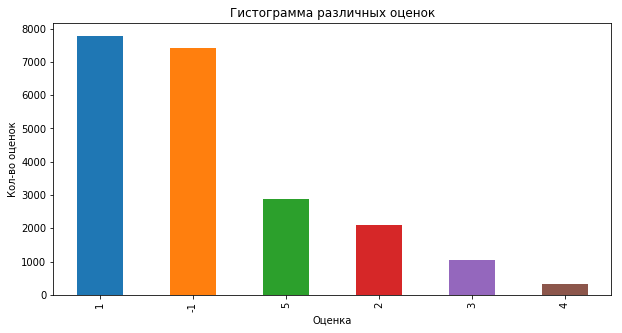

In [241]:
plt.figure(figsize=(10, 5))
plt.title(u"Гистограмма различных оценок")
plt.ylabel(u"Кол-во оценок")
plt.xlabel(u"Оценка")
replies.mark.value_counts().plot(kind="bar")

Как часто пользователи пишут комментарии?

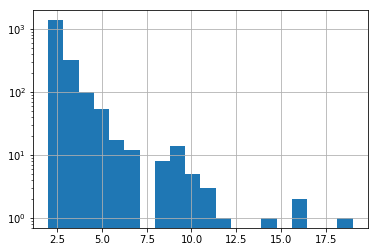

In [242]:
comment_frequency = replies.author.value_counts()
fig, ax = plt.subplots()
comment_frequency[comment_frequency > 1].hist(bins=20)
ax.set_yscale('log')

Большинство пользователей оставляет пару комментариев. Посмотрим отдельно на активных пользователей

In [243]:
pd.set_option("display.max_rows", 100)
replies_top_pop = replies[replies.author.isin(comment_frequency[comment_frequency > 10].index)]
replies_top_pop.shape

(110, 10)

In [244]:
replies_top_pop.groupby("author")["mark"].value_counts().unstack(fill_value=0)

mark,-1,1,2,3,4,5
author,,,,,,
John Wayne,8,1,3,0,1,1
chlotus,10,5,1,1,1,1
craft87,7,3,3,1,1,1
evgus,7,0,2,1,1,0
mi_chel,7,2,1,0,1,0
webber,7,5,3,1,0,0
ВорчливаяПанда,8,0,1,0,1,2
Гога,4,3,1,1,1,1


### Загрузка метаданных о банках

In [596]:
import requests
import json
import logging
import codecs
from bs4 import BeautifulSoup
import tqdm
from lxml.etree import ElementTree
import html
import pandas as pd
from selenium import webdriver

In [18]:
os.system("scrapy startproject banksru")

256

In [593]:
class BanksSpider(scrapy.Spider):
    name = "banks"
    start_urls = [
        'http://www.banki.ru/services/responses/',
    ]

    def __init__(self):
        self.driver = webdriver.Chrome()

    def spider_closed(self, spider):
        self.driver.close()
        
    def parse(self, response):
        self.driver.get(response.url)
        #parse with selenium

In [594]:
url = 'http://www.banki.ru/services/responses/'

In [ ]:
driver = webdriver.Chrome()

In [ ]:
driver.get(url)

In [ ]:
print(driver.title)

In [ ]:
elements = driver.find_elements_by_class_name("item")

In [ ]:
rows = []
for element in elements:
    blocks = element.find_elements_by_xpath("td")[1:-1]
    rows.append(map(lambda x: x.text, blocks))

In [ ]:
data = data = pd.DataFrame(rows, columns=["Банк", "Рейтинг", "Средняя оценка", "Зачтено отзывов", "Решено проблем", "Ответов банка"]) 

In [ ]:
data.head()

#### Было бы интересно посмотреть на пользователей, которые поставили противоричивые отзывы об одном банке?

Пользователи, оставившие разные комментарии, могли изменить свое мнение насчет банка. Если их проблема быстро решалась, то, возможно, появлялся положительный отзыв.

#### Сильно ли отличаются даты этих комментариев? (Может банк решил проблему или же наоборот стало хуже с обслуживанием)

#### Используют ли пользователи сайта одновременно несколько банков?

#### Можно ли судить об оттоке пользователей если проанализировать динамику оценок во времени?

Посчитаем число уникальных ответов банка. Причина не уникальности ответов может заключаться в том, что банки имеют стандартные ответы на некоторые вопросы или проблемы. Например, в своём ответе они могут попросить пользователя обратится в службу поддержки или позвонить по указанному номеру.

In [245]:
print "Уникальных {} ответов из {}".format(len(replies.bank_response.unique()), len(replies.bank_response))

Уникальных 15794 ответов из 21572


Практически все отзывы уникальные. Пользователи копируют отзывы в случае когда хотят донести до банка некоторую проблему.

In [246]:
print "Уникальных {} отзывов из {}".format(len(replies.text.unique()), len(replies.text))

Уникальных 21570 отзывов из 21572


Заметим, что в отзывах есть лишние символы конца строки, удалим их.

In [247]:
replies.text = replies.text.apply(lambda line: re.sub(u'\n', u' ', line))

Заголовки отзывов довольно часто повторяются.

In [248]:
replies.title.value_counts()[:10]

Благодарность            264
Навязывание страховки     64
Ипотека                   45
Жалоба                    39
Претензия                 37
Обслуживание              37
Рефинансирование          37
Отличное обслуживание     37
Телебанк                  34
Ужасное обслуживание      32
Name: title, dtype: int64

In [249]:
replies[['text']].head()

,text
43781,Добрый день! хочу поделиться своими впечатле...
43795,Здравствуйте! 05.04.17 года я обратился по тел...
43796,Здравствуйте. С 2011 годы являюсь клиентом бан...
43808,Добрый день! Являюсь руководителем компании у ...
43809,Продолжительное время являюсь клиентом ВТБ 24 ...


Разделим отзывы на предложения.

In [250]:
sentences = []
replies_id = []
for index, reply in tqdm.tqdm(replies.text.iteritems()):
    current_sentences = sent_tokenize(reply)
    sentences += current_sentences
    replies_id += [index]*len(current_sentences)

21572it [00:49, 431.76it/s]


In [23]:
sentences_replies = pd.DataFrame()
sentences_replies[COLUMN_SENTENCE] = sentences
sentences_replies[COLUMN_REPLY_ID] = replies_id

In [24]:
sentences_replies.head()

,sentence,reply_id
0,Добрый день!,43781
1,хочу поделиться своими впечатлениями от банка ...,43781
2,"вообще, кредит я в ВТБ не брала, но... мой пот...",43781
3,"Соглашусь, не от большого ума, я тоже решила о...",43781
4,Через время со мной связался С... из службы вз...,43781


## Предобработка данных

**Успех зависит на 80%(с потолка) от качества предобработка данных.**

В силу того что естественный язык содержит много шумовой информации, очень важно сделать качественную предобработку данных.

В данном эксперименте:
* удалим специальные символы
* удалим низкочастотные слова
* лемматизируем текст
* проведем синтаксический разбор
* отфильтруем слова по частям речи
* выделим устойчивые словосочетания (коллокации)

### Очистим данные от специальных символов

Оставим лишь буквы русского языка, приведем к нижнему регистру.

In [25]:
def deleteExtraSymbols(line):
    if line:
        return re.sub(' +',' ', re.sub(ur'[^А-Яа-я ]', u' ', line).lower().rstrip().strip())
    else:
        return None

In [26]:
sentences_replies[COLUMN_DELETE_EXTRA_SYMBOLS] = sentences_replies.sentence.apply(deleteExtraSymbols)

In [ ]:
sentences_replies.head()

In [ ]:
sentences_replies.shape

Удалим пустые строки

In [ ]:
sentences_replies = sentences_replies[sentences_replies.deleted_extra_symbols != ""]

In [ ]:
sentences_replies.shape

Сохраним данные

In [ ]:
sentences_replies.to_pickle(os.path.join(DATA_PATH, "sentences_replies.pkl"))
replies.to_pickle(os.path.join(DATA_PATH, "replies.pkl"))

Загрузим данные

In [27]:
sentences_replies = pd.read_pickle(SENTENCES_REPLIES)

In [213]:
sentences_replies.head()

,sentence,reply_id,deleted_extra_symbols
0,Добрый день!,43781,добрый день
1,хочу поделиться своими впечатлениями от банка ...,43781,хочу поделиться своими впечатлениями от банка ...
2,"вообще, кредит я в ВТБ не брала, но... мой пот...",43781,вообще кредит я в втб не брала но мой потреб с...
3,"Соглашусь, не от большого ума, я тоже решила о...",43781,соглашусь не от большого ума я тоже решила отд...
4,Через время со мной связался С... из службы вз...,43781,через время со мной связался с из службы взыск...


In [5]:
replies = pd.read_pickle(REPLIES)

### Синтаксический анализ

Подготовим входные данные для SyntaxNet

In [29]:
sentences_replies[sentences_replies.deleted_extra_symbols.str.len() > 100].shape

(108820, 3)

In [30]:
sentences_replies.deleted_extra_symbols[sentences_replies.deleted_extra_symbols != ""].shape

(350108,)

In [63]:
with codecs.open(SYNTAXNET_INPUT, "w", encoding="utf-8") as output:
    print >> output, "\n".join(sentences_replies.deleted_extra_symbols)

In [64]:
total_words = -0
for line in sentences_replies['deleted_extra_symbols'].iteritems():
    total_words += len(line[1].split(' '))

#### Проведем синтаксический анализ предложений

[SyntaxNet](https://github.com/tensorflow/models/tree/master/syntaxnet) - инструмент для синтаксического разбора. 

Для сборки SyntaxNet из исходников требуется 12gb RAM. В случае нехватки ресурсов можно воспользоваться [Docker image](https://hub.docker.com/r/evgenysmirnov/syntaxnet/).

In [67]:
start_time = time.time()
if os.system("docker run -v /Users/maksim/TinkoffML/5part/TopicModelingFintech/vtb24/:/data evgenysmirnov/syntaxnet") != 0:
    print "ERROR_SYNTAX_NET"
print "It took {:.2f} seconds".format(time.time() - start_time)

It took 2812.39 seconds


## Обработаем выход SyntaxNet:
* Селекция столбцов
* Именование столбцов
* Добавим колонку с лематизированным словами
* Индексация с нуля

**Лемматизация** — процесс приведения слова к нормальной форме.

В русском языке нормальными формами считаются следующие морфологические формы:

* для существительных — именительный падеж, единственное число;
* для прилагательных — именительный падеж, единственное число, мужской род;
* для глаголов, причастий, деепричастий — глагол в инфинитиве.

Более того, заменим все имена одним токеном "имя".

**Библиотеки для лемматизации**:
* pymorphy2 (русский)
* mystem3 (русский)
* Wordnet Lemmatizer (NLTK, язык английский, требует POS метку)
* Metaphraz (язык русский)
* Coda/Cadenza (языки русский и английский)

**Примеры лемматизации:**
- живу -> жить
- здравструйте -> здравствовать
- положительная -> положительный
- ип -> ипать

In [47]:
import pandas as pd
import numpy as np
import os, csv
import regex as re
from subprocess import call
import codecs
from tools import checkDirectory, dynamicPrint
import pickle
from preprocess_line import lemmatize
from pymystem3 import Mystem

In [48]:
mystem = Mystem()
mystem.lemmatize("прыгавший")[0].decode('utf-8')

u'\u043f\u0440\u044b\u0433\u0430\u0442\u044c'

In [71]:
WORD_ID = "word_id"
WORD = "word"
PARENT_ID = "parent_id"
TAG = "tag"
DEPENDENCY = "dependency"
SENTENCE_ID = "sentence_id"
LEMMATIZED = "lemmatized"
file_from = SYNTAXNET_OUTPUT
from_syntaxnet = pd.read_table(file_from, encoding="utf-8", header=None, dtype={0: np.int32, 6: np.int32},
                                   quoting=csv.QUOTE_NONE, engine="c")[[0, 1, 6, 3, 7]].fillna("")
from_syntaxnet.columns = [[WORD_ID, WORD, PARENT_ID, TAG, DEPENDENCY]]
from_syntaxnet[WORD_ID] -= 1
from_syntaxnet[PARENT_ID] -= 1

sentence_id = -1
sentences_id = []
lemmatized = []
words = []

lines_n = len(from_syntaxnet)
mystem = Mystem()

In [72]:
from_syntaxnet.head(5)

,word_id,word,parent_id,tag,dependency
0,0,в,2,ADP,case
1,1,третий,2,ADJ,amod
2,2,раз,10,NOUN,nmod
3,3,для,4,ADP,case
4,4,решения,10,NOUN,nmod


In [73]:
from_syntaxnet.shape

(1178497, 5)

In [74]:
ids_list = map(lambda x: x[0], from_syntaxnet['word_id'].as_matrix())
len(ids_list)

1178497

In [75]:
words_list = map(lambda x: x[0], from_syntaxnet['word'].as_matrix())
len(words_list)

1178497

In [76]:
idxs_words = zip(ids_list, words_list)
len(idxs_words)

1178497

In [77]:
for index, (word_id, word) in enumerate(idxs_words):
    if index % 10000 == 0:
        dynamicPrint("line {} from {}".format(index, lines_n))

    if word_id == 0:
        sentence_id += 1
        lemmatized += lemmatize(" ".join(words), mystem)
        words = []

    words.append(word)
    sentences_id.append(sentence_id)
    
lemmatized += lemmatize(" ".join(words), mystem)

line 1170000 from 1178497

In [78]:
print len(lemmatized), len(sentences_id)

1178497 1178497


In [79]:
from_syntaxnet[SENTENCE_ID] = sentences_id
from_syntaxnet[LEMMATIZED] = lemmatized

In [80]:
from_syntaxnet.head(5)

,word_id,word,parent_id,tag,dependency,sentence_id,lemmatized
0,0,в,2,ADP,case,0,в
1,1,третий,2,ADJ,amod,0,третий
2,2,раз,10,NOUN,nmod,0,раз
3,3,для,4,ADP,case,0,для
4,4,решения,10,NOUN,nmod,0,решение


In [81]:
from_syntaxnet.shape

(1178497, 7)

In [119]:
LEMM_PATH = FOLDER_DATA + 'from_syntaxnet.pkl'

In [120]:
with open(LEMM_PATH, 'wb') as f:
    pickle.dump(from_syntaxnet ,f)

## Соберем словарь коллекции

**Словарь** --- множество уникальных слов в коллекции

Посчитаем частоты слов в корпусе

In [121]:
from collections import defaultdict

In [122]:
lemm_words = map(lambda x: x[0], from_syntaxnet.lemmatized.values)

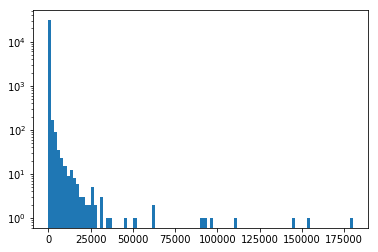

In [123]:
word_frequency = defaultdict(int)
for word in lemm_words:
    word_frequency[word] += 1

plt.hist(word_frequency.values(), bins=100)
plt.yscale("log")

In [124]:
print("Number of unique words: %d" %(len(word_frequency)))

Number of unique words: 31132


Фоновая лексика содержится в высокочастотных словах

In [126]:
for word, frequency in word_frequency.iteritems():
    if frequency > 20000:
        print word

имя
который
о
кредит
что
а
клиент
за
в
по
деньги
не
на
но
то
мой
сотрудник
быть
как
втб
и
это
с
к
этот
у
банк
карта
день
я


Низкочастотные слова довольно часто содержат опечатки, логины автором и прочие малозначимые сущности

In [135]:
MIN_FREQUENCY = 5

In [136]:
rare_words = [key for key, value in word_frequency.iteritems() if value < MIN_FREQUENCY]
print " ".join(np.random.choice(rare_words, 50))

толерантный пересыл этомвтба мешаться сестрорецк насолить безмятежный госконкурент шалить фортс промокод селенгинск сурь миокард мобилизация притаскиваться ашхабадский нпр королевство оптимум отметаться доглядывать забанивать весчъ котолевской совладелец диал сдвать юкб спирать потомственный пронестись разморозиться непубликуемый спроваживать спартаковский кирпичный пожива правопорядок идеологический невстребовать сверхважный солнышко нечистый предложеный онкоцентр стац въездной отдуваться асинхронность


In [137]:
print("Number of words with frequency less than %d: %d" %(MIN_FREQUENCY, len(rare_words)))

Number of words with frequency less than 5: 18741


Удалим низкочастотные слова, так как они не внесут статистической силы, а лишь увеличат потребление ресурсов

Отобрано 11319 слов из 31132


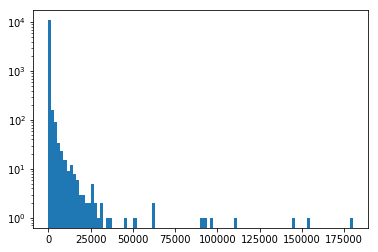

In [138]:
word_frequency_selected = {word: frequency for word, frequency in word_frequency.iteritems() if frequency > MIN_FREQUENCY}
print "Отобрано {} слов из {}".format(len(word_frequency_selected), len(word_frequency))
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(word_frequency_selected.values(), bins=100)
plt.yscale("log")

In [139]:
vocab = set(word_frequency_selected.keys())

## Выделение синтаксических веток в дереве
Синтаксическая ветка --- последовательность слов от корня дерева до любого из его листьев.

Оствавим в коллекции лишь слова из словаря.

Сделаем фильтрацию по частям речи.

In [140]:
class Branches():
    class outputData:

        def __init__(self):
            self.sentence_id = []
            self.branch_id = []
            self.branch = []
            self.branch_ids_local = []
            self.branch_ids_global = []

        def addValues(self, SENTENCE_ID, BRANCH_ID, BRANCH, WORD_IDS_LOCAL=None, WORD_IDS_GLOBAL=None):
            self.sentence_id.append(SENTENCE_ID)
            self.branch_id.append(BRANCH_ID)
            self.branch.append(BRANCH)
            if WORD_IDS_LOCAL:
                self.branch_ids_local.append(WORD_IDS_LOCAL)
            if WORD_IDS_GLOBAL:
                self.branch_ids_global.append(WORD_IDS_GLOBAL)

        def getDataFrame(self):

            import pandas as pd

            SENTENCE_ID = "sentence_id"
            WORD_IDS_LOCAL = "word_ids_local"
            WORD_IDS_GLOBAL = "word_ids_global"
            BRANCH = "branch"
            BRANCH_ID = "branch_id"

            dataFrame = pd.DataFrame()
            dataFrame[SENTENCE_ID] = self.sentence_id
            dataFrame[BRANCH_ID] = self.branch_id
            dataFrame[BRANCH] = self.branch

            return dataFrame


    def __init__(self, vocab=None, stop_words=None, bad_tags={u'ADP', U'CONJ', U'AUX', U'PRON', U'NUM', U'SCONJ'}):
        self.dictionary_pairs = dict()
        self.dictionary_frequency = dict()
        self.bad_tags = bad_tags
        self.stop_words = stop_words
        self.vocab = vocab
        if self.vocab:
            self.check = self.vocab_check
        else:
            self.check = self.stop_word_check
        self.error_number = 0
        self.outputData = self.outputData()
        self.passNext = False

    def stop_word_check(self, word):
        return word in self.stop_words

    def vocab_check(self, word):
        return not (word in self.vocab)

    def addValues(self, words, parent_ids, tags, sentence_id, word_ids_local, word_ids_global=None, save_local_ids=True, window_size=2,
                  addTags=True):

        if self.passNext:
            self.passNext = False
            return

        ROOT = -1
        DELETED = -2

        leafes = set(range(len(word_ids_local)))
        max_parent = len(word_ids_local) - 1
        not_leafes = set()
        deleted = set()

        len_number = len(words)

        for i in xrange(len_number):
            word, word_id_local, tag, parent_id = words[i], word_ids_local[i], tags[i], parent_ids[i]
            
            if parent_id > max_parent or parent_id == word_id_local:
                self.passNext = True
                print "error", parent_id, max_parent, word_id_local, parent_id > max_parent, parent_id == word_id_local
                return
            if parent_id != DELETED and (self.check(word) or tag in self.bad_tags):

                for j in xrange(len(words)):
                    if parent_ids[j] == word_id_local:
                        parent_ids[j] = parent_id

                parent_ids[i] = DELETED
                leafes.remove(i)
                deleted.add(i)

            elif addTags:
                if word in self.dictionary_frequency:
                    self.dictionary_frequency[word] += 1
                else:
                    self.dictionary_frequency[word] = 1

        for word_id, parent_id in zip(word_ids_local, parent_ids):
            if parent_id != DELETED:
                not_leafes.add(parent_id)

        not_leafes.difference({ROOT})
        leafes.difference_update(not_leafes)
        if word_ids_global and save_local_ids:
            branch_elements = zip(tags, words, word_ids_local, word_ids_global)
        elif save_local_ids:
            branch_elements = zip(tags, words, word_ids_local)
        else:
            branch_elements = zip(tags, words)


        branch_id = 0

        for leaf in leafes:
            search_element = leaf
            new_branch = []

            while search_element != ROOT:
                if search_element not in deleted:
                    new_branch.append(branch_elements[search_element])
                search_element = parent_ids[search_element]

            if len(new_branch) > 1:
                new_branch.reverse()
                extracted = zip(*new_branch)
                if addTags:
                    self.addTags(zip(extracted[0], extracted[1]), window_size)
                if word_ids_global and save_local_ids:
                    self.outputData.addValues(sentence_id, branch_id, " ".join(extracted[1]),
                                          list(extracted[2]), list(extracted[3]))
                elif save_local_ids:
                    self.outputData.addValues(sentence_id, branch_id, " ".join(extracted[1]),
                                              list(extracted[2]))
                else:
                    self.outputData.addValues(sentence_id, branch_id, " ".join(extracted[1]))
                branch_id += 1

    def addTags(self, branch, window_size):

        if len(branch) >= window_size:

            tags = []
            words = []

            for i, element in enumerate(branch):
                tag, word = element
                if tag not in self.bad_tags:
                    tags.append(tag)
                    words.append(word)
                else:
                    continue

                if i >= window_size - 1:
                    words_tuple = tuple(sorted(words))
                    tags_tuple = tuple(sorted(tags))
                    try:
                        self.dictionary_pairs[tags_tuple][words_tuple] += 1
                    except:
                        try:
                            self.dictionary_pairs[tags_tuple][words_tuple] = 1
                        except:
                            self.dictionary_pairs[tags_tuple] = {words_tuple: 1}
                    del tags[0], words[0]


    def addDataFrame(self, data, addTags=True, save_global_ids=True, save_local_ids=True):

        from tools import dynamicPrint

        SENTENCE_ID = "sentence_id"
        WORD_ID = "word_id"
        WORD = "lemmatized"
        TAG = "tag"
        PARENT_ID = "parent_id"

        start_row = data.iloc[0]
        current_sentence_id = start_row.sentence_id.values[0]

        word_ids_local = []
        if save_global_ids:
            word_ids_global = []
        else:
            word_ids_global = None
        words = []
        tags = []
        parent_ids = []

        words_n = len(data)

        i = 0
        
        for index, row in data.iterrows():
            if i % 10000 == 0:
                dynamicPrint("word {} from {}\n".format(i, words_n))
            sentence_id = row.sentence_id.values[0]
            if sentence_id != current_sentence_id:

                if len(word_ids_local) > 1:
                    self.addValues(words, parent_ids, tags, current_sentence_id, word_ids_local, word_ids_global, save_local_ids, addTags=addTags)
                word_ids_local = []
                if save_global_ids:
                    word_ids_global = []
                words = []
                tags = []
                parent_ids = []
                current_sentence_id = sentence_id

            word_ids_local.append(row.word_id.values[0])
            if save_global_ids:
                word_ids_global.append(index)
            words.append(row.word.values[0])
            tags.append(row.tag.values[0])
            parent_ids.append(row.parent_id.values[0])

            i += 1

        self.addValues(words, parent_ids, tags, current_sentence_id, word_ids_local, word_ids_global, addTags=addTags)

    def dump_dictionaries(self, path):
        import pickle
        pickle.dump(self.dictionary_frequency, open(path + "dictionary_frequency.pkl", "wb"))
        pickle.dump(self.dictionary_pairs, open(path + "dictionary_pairs.pkl", "wb"))


In [141]:
branches = Branches(vocab=vocab, bad_tags={u'ADP', U'CONJ', U'AUX', U'PRON', U'NUM', U'SCONJ'})

Получим синтаксические ветки из дерева синтаксического разбора. 

Для каждой пары частей речи составим словарь частот соответствующих им словосочетаний (**addTags**).

In [154]:
branches.addDataFrame(from_syntaxnet, addTags=True, save_global_ids=False, save_local_ids=False)

word 0 from 4778121
word 10000 from 4778121
word 20000 from 4778121
word 30000 from 4778121
word 40000 from 4778121
word 50000 from 4778121
word 60000 from 4778121
word 70000 from 4778121
word 80000 from 4778121
word 90000 from 4778121
word 100000 from 4778121
word 110000 from 4778121
word 120000 from 4778121
word 130000 from 4778121
word 140000 from 4778121
word 150000 from 4778121
word 160000 from 4778121
word 170000 from 4778121
word 180000 from 4778121
word 190000 from 4778121
word 200000 from 4778121
word 210000 from 4778121
word 220000 from 4778121
word 230000 from 4778121
word 240000 from 4778121
word 250000 from 4778121
word 260000 from 4778121
word 270000 from 4778121
word 280000 from 4778121
word 290000 from 4778121
word 300000 from 4778121
word 310000 from 4778121
word 320000 from 4778121
word 330000 from 4778121
word 340000 from 4778121
word 350000 from 4778121
word 360000 from 4778121
word 370000 from 4778121
word 380000 from 4778121
word 390000 from 4778121
word 400000 fr

In [155]:
branches_data = branches.outputData.getDataFrame()
branches.dump_dictionaries(FOLDER_DATA)
branches_data.to_pickle(BRANCHES)
print "\nЧисло веток - {}".format(len(branches_data))
branches_data.head(10)


Число веток - 496146


,sentence_id,branch_id,branch
0,0,0,день добрый
1,2,0,потреб мой
2,2,1,исправно не
3,2,2,исправно не
4,2,3,исправно юр
5,2,4,исправно мирно
6,2,5,исправно вопрос
7,3,0,кредит свой
8,3,1,рассказывать не
9,2,0,потреб мой


### Отбор терминов

Для отбора терминов используем трехэтапный метод фильтрации:
* синтаксическая связность
* высокая частотность
* высокий pmi

In [156]:
# вычислим n_uv
def getWordsCounts(pair_dictionary):
    n_words = defaultdict(int)
    for pair in pair_dictionary:
        word1, word2 = pair
        n_words[word1] += 1
        n_words[word2] += 1
    return n_words

def filter_pairs(pairs, threshold_frequency, threshold_pmi):
    pairs_sorted = sorted(pairs.items(), key=operator.itemgetter(1), reverse=True)
    n_words = getWordsCounts(pairs)
    n_total = sum(n_words.values())
    new_elements = []
    for element in pairs_sorted:
        word1, word2 = element[0]
        n_pair = element[1]
        if n_pair > threshold_frequency:
            pmi = log(float(n_pair) / n_words[word1] / n_words[word2] * n_total)
            if pmi > threshold_pmi:
                new_elements.append(((" ".join(element[0])), n_pair, pmi))
    return new_elements

Отфильтруем по частоте и pmi и запишем на диск для дальнейшего анализа, группируя по парам частей речи.

In [163]:
FOLDER_COLLOCATION = FOLDER_DATA + "collocations/"

checkDirectory(FOLDER_COLLOCATION)
        
for key, pairs in branches.dictionary_pairs.iteritems():
    elements = filter_pairs(pairs, 50, 3)
    if elements:
        
        output = []
        for element in elements:
            output.append(u"{}: {} {:2}".format(element[0], element[1], element[2]))
                
        with codecs.open("{}{}.txt".format(FOLDER_COLLOCATION, key), "w", encoding="utf-8") as ouputFile:
            print >> ouputFile, "\n".join(output)

In [164]:
collocations = []
for file_name in os.listdir(FOLDER_COLLOCATION):
    if not file_name.startswith("."):
        with codecs.open(FOLDER_COLLOCATION + file_name, encoding="utf-8") as input_file:
            collocations += [line.split(":")[0] for line in input_file.read().splitlines()]
with codecs.open(COLLOCATIONS, "w", encoding="utf-8") as output_file:
    print >> output_file, "\n".join(collocations)
print "Выделено коллокаций - {}".format(len(collocations))

Выделено коллокаций - 1273


Найдем все вхождения коллокаций и объединим слова в них нижним подчеркиванием.

**Пример:**
- карта кредитный -> карта_кредитный
- положительный решение -> положительный_решение

In [166]:
collocations = []

for collocation in getListFromFile(COLLOCATIONS):
    collocations.append(CollocationSyntax(collocation))
    
collocations_n = len(collocations)
    
all_branches = "\n".join(list(branches_data.branch))
    
for collocation in collocations:
    all_branches = add_collocation(all_branches, collocation)
branches_data.branch = all_branches.split("\n")

In [170]:
BRANCHES_DATA_PATH = FOLDER_DATA + 'processed_branches.pkl'
branches_data.to_pickle(BRANCHES_DATA_PATH)

#### Load preprocessed data

In [206]:
branches_data = pd.read_pickle(BRANCHES)

In [220]:
branches_data.shape

(1613641, 3)

In [209]:
branches_data.head()

,sentence_id,branch_id,branch
2922121,634075,0,объяснять заша_л отдел кредитный
2922122,634075,1,объяснять там
2922123,634075,2,объяснять вс
2922124,634075,3,объяснять грамотно
2922125,634075,4,объяснять документ какой


In [210]:
branches_data.index = range(len(branches_data.index))

In [222]:
branches_data.head(5)

,sentence_id,branch_id,branch
0,634075,0,объяснять заша_л отдел кредитный
1,634075,1,объяснять там
2,634075,2,объяснять вс
3,634075,3,объяснять грамотно
4,634075,4,объяснять документ какой


In [225]:
branches_data.groupby('sentence_id').count().shape

(333872, 2)

In [296]:
sentences_replies.shape

(349657, 6)

In [216]:
sentences_replies.head()

,sentence,reply_id,deleted_extra_symbols
0,Добрый день!,43781,добрый день
1,хочу поделиться своими впечатлениями от банка ...,43781,хочу поделиться своими впечатлениями от банка ...
2,"вообще, кредит я в ВТБ не брала, но... мой пот...",43781,вообще кредит я в втб не брала но мой потреб с...
3,"Соглашусь, не от большого ума, я тоже решила о...",43781,соглашусь не от большого ума я тоже решила отд...
4,Через время со мной связался С... из службы вз...,43781,через время со мной связался с из службы взыск...


## Преобразование данных в формат Vowpal Wabbit

Vowpal Wabbit базируется на следующих принципах:

* каждый документ записывается в одну строку
* все токены представлены в строковом формате (не требуется делать токенизацию)
* стадартная частота токенов = 1.0, чтобы ее изменить нужно указать ее значения после символа через двоеточие
* модальность токена идентифицируется символом (|)

#### Формат данных:
** `[<title>] [|@modality_class] {token[:counter]}` **

[Форматы входных данных](http://bigartm.readthedocs.io/en/stable/tutorials/datasets.html)

### Документ = предложение

**Пример строк входного файла:**

0  |@default_class когда:5 долгий:1 разница:1 спокойно:2 один:2 возможный:1 неизвестно:1

20  |@default_class перев:3 испробовать:1 деньги:3 сказать:1 открывать:1 один:1 первый:1

Нам потребуются два типа документов: отзыв, предложение.

Предложения будем формировать как объединение слов соответствующих ему синтаксических веток. Тем самым мы отнормируем вес слов в зависимости от их синтаксической значимости.

In [294]:
current_sentence_id

3811459

In [295]:
branches_data.head()

,sentence_id,branch_id,branch
0,634075,0,объяснять заша_л отдел кредитный
1,634075,1,объяснять там
2,634075,2,объяснять вс
3,634075,3,объяснять грамотно
4,634075,4,объяснять документ какой


In [300]:
sentences_replies.head()

,sentence,reply_id,deleted_extra_symbols,lemmatized,vocab_only,vw
634075,Добрый день!,43781,добрый день,добрый день,добрый день,"{u'день': 1, u'добрый': 1}"
634076,хочу поделиться своими впечатлениями от банка ...,43781,хочу поделиться своими впечатлениями от банка ...,хотеть поделиться свой впечатление от банк в ц...,хотеть поделиться свой впечатление от банк в ц...,"{u'банк': 1, u'поделиться': 1, u'впечатление_п..."
634077,"вообще, кредит я в ВТБ не брала, но... мой пот...",43781,вообще кредит я в втб не брала но мой потреб с...,вообще кредит я в втб не брать но мой потреба ...,вообще кредит я в втб не брать но мой потреба ...,"{u'брать': 18, u'вопрос': 1, u'туда': 1, u'кот..."
634078,"Соглашусь, не от большого ума, я тоже решила о...",43781,соглашусь не от большого ума я тоже решила отд...,соглашаться не от большой ум я тоже решать отд...,соглашаться не от большой ум я тоже решать отд...,"{u'виноватый': 1, u'заслуживать': 1, u'клиент'..."
634079,Через время со мной связался С... из службы вз...,43781,через время со мной связался с из службы взыск...,через время со я связываться с из служба взыск...,через время со я связываться с из служба взыск...,"{u'время': 1, u'история': 4, u'отвечать': 1, u..."


In [291]:
current_sentence_id = branches_data.loc[0].sentence_id
current_vw = dict()
sentences = dict()
sentences_replies_indexes = list(sentences_replies.index)
for _, row in branches_data[["sentence_id", "branch"]].iterrows():
    sentence_id = row.sentence_id
    branch = row.branch
    
    if sentence_id != current_sentence_id:
        sentences[current_sentence_id] = current_vw
        current_index += 1
        current_vw = dict()
        current_sentence_id = sentence_id
        
    for word in branch.split():
        if word in current_vw:
            current_vw[word] += 1
        else:
            current_vw[word] = 1
sentences[current_sentence_id] = current_vw
sentences_replies["vw"] = pd.Series(sentences)

In [304]:
output_vw = []
for index, vw_dict in sentences_replies.vw.dropna().iteritems():
    sentence = [u"{}:{}".format(word, frequency) for word, frequency in vw_dict.iteritems()]
    output_vw.append(u"{} |@default_class {}".format(index, " ".join(sentence)))
    
with codecs.open(FOLDER_DATA + "vw_sentences.txt", "w", encoding="utf-8") as output:
    print >> output, "\n".join(output_vw)

In [306]:
sentences_replies.head()

,sentence,reply_id,deleted_extra_symbols,lemmatized,vocab_only,vw
634075,Добрый день!,43781,добрый день,добрый день,добрый день,"{u'день': 1, u'добрый': 1}"
634076,хочу поделиться своими впечатлениями от банка ...,43781,хочу поделиться своими впечатлениями от банка ...,хотеть поделиться свой впечатление от банк в ц...,хотеть поделиться свой впечатление от банк в ц...,"{u'банк': 1, u'поделиться': 1, u'впечатление_п..."
634077,"вообще, кредит я в ВТБ не брала, но... мой пот...",43781,вообще кредит я в втб не брала но мой потреб с...,вообще кредит я в втб не брать но мой потреба ...,вообще кредит я в втб не брать но мой потреба ...,"{u'брать': 18, u'вопрос': 1, u'туда': 1, u'кот..."
634078,"Соглашусь, не от большого ума, я тоже решила о...",43781,соглашусь не от большого ума я тоже решила отд...,соглашаться не от большой ум я тоже решать отд...,соглашаться не от большой ум я тоже решать отд...,"{u'виноватый': 1, u'заслуживать': 1, u'клиент'..."
634079,Через время со мной связался С... из службы вз...,43781,через время со мной связался с из службы взыск...,через время со я связываться с из служба взыск...,через время со я связываться с из служба взыск...,"{u'время': 1, u'история': 4, u'отвечать': 1, u..."


## Документ = отзыв

In [307]:
output_vw = []
current_reply_id = sentences_replies.iloc[0].reply_id
reply_words = dict()

for _, row in sentences_replies[["vw", "reply_id"]].dropna().iterrows():
    vw_dict = row["vw"]
    reply_id = row["reply_id"]
    
    if reply_id != current_reply_id:
        reply = [u"{}:{}".format(word, frequency) for word, frequency in reply_words.iteritems()]
        output_vw.append(u"{} |@default_class {}".format(current_reply_id, " ".join(reply)))
        reply_words = dict()
        current_reply_id = reply_id
        
    for word, frequency in vw_dict.iteritems():
        if word in reply_words:
            reply_words[word] += frequency
        else:
            reply_words[word] = frequency
reply = [u"{}:{}".format(word, frequency) for word, frequency in reply_words.iteritems()]
output_vw.append(u"{} |@default_class {}".format(current_reply_id, " ".join(reply)))
            
with codecs.open(FOLDER_DATA + "vw_replies.txt", "w", encoding="utf-8") as output:
    print >> output, "\n".join(output_vw)

## VW для своего словаря тональностей

In [313]:
sentences_replies.head(3)

,sentence,reply_id,deleted_extra_symbols,lemmatized,vocab_only,vw
634075,Добрый день!,43781,добрый день,добрый день,добрый день,"{u'день': 1, u'добрый': 1}"
634076,хочу поделиться своими впечатлениями от банка ...,43781,хочу поделиться своими впечатлениями от банка ...,хотеть поделиться свой впечатление от банк в ц...,хотеть поделиться свой впечатление от банк в ц...,"{u'банк': 1, u'поделиться': 1, u'впечатление_п..."
634077,"вообще, кредит я в ВТБ не брала, но... мой пот...",43781,вообще кредит я в втб не брала но мой потреб с...,вообще кредит я в втб не брать но мой потреба ...,вообще кредит я в втб не брать но мой потреба ...,"{u'брать': 18, u'вопрос': 1, u'туда': 1, u'кот..."


In [317]:
sentences_replies.shape

(349657, 6)

In [312]:
output_vw = []
current_reply_id = sentences_replies.iloc[0].reply_id
reply_words = dict()
sentiment_indexes = list(replies[replies.mark != -1].index)
sentences_replies_sentiment = sentences_replies[sentences_replies.reply_id.isin(sentiment_indexes)]

In [316]:
sentences_replies_sentiment.shape

(238203, 6)

In [314]:
for _, row in sentences_replies_sentiment[["vw", "reply_id"]].dropna().iterrows():
    vw_dict = row["vw"]
    reply_id = row["reply_id"]
    
    if reply_id != current_reply_id:
        reply = [u"{}:{}".format(word, frequency) for word, frequency in reply_words.iteritems()]
        output_vw.append(u"{} |@default_class {}".format(current_reply_id, " ".join(reply)))
        reply_words = dict()
        current_reply_id = reply_id
        
    for word, frequency in vw_dict.iteritems():
        if word in reply_words:
            reply_words[word] += frequency
        else:
            reply_words[word] = frequency
reply = [u"{}:{}".format(word, frequency) for word, frequency in reply_words.iteritems()]
output_vw.append(u"{} |@default_class {}".format(current_reply_id, " ".join(reply)))
            
with codecs.open(FOLDER_DATA + "vw_sentiment.txt", "w", encoding="utf-8") as output:
    print >> output, "\n".join(output_vw)

## WNTM псевдо-документы

абсурдный |@default_class абсолютно:8 авангард:1 адрес:5 альфа:1 аргумент:1 аргументировать:1 ассоциироваться:1 банк:22 банкомат:1 безобразие:1 бесплатный:2 

сопротивляться |@default_class активно:2 анкета:1 аннулирование:1 аргумент:1 банк:21 барышня:1 блокировка:1 более:2 брать:1 бухгалтер:1 бы:2 быдло:2 быть:7 ведь:1 вежливость:1

Входные аргументы:
- **lines** - список строк
- **output_dir** - куда положить выходные данные
- **window** - ширина окна

в **output_dir** будут:
- **vw_ww.txt** - псевдо-документы в vw формате
- **pmi.txt** - счетчики совстречаемости
- **vocab.txt** - словарь коллекции

In [365]:
prepare_vw_wntm_pmi_vocab(lines=branches_data.branch, output_dir=FOLDER_DATA, window=5)

100%|██████████| 1613641/1613641 [00:52<00:00, 30924.55it/s]


save wv to /Users/maksim/TinkoffML/5part/TopicModelingFintech/vtb24/ww_vw.txt



100%|██████████| 3197192/3197192 [00:11<00:00, 277851.94it/s]


save vocab to /Users/maksim/TinkoffML/5part/TopicModelingFintech/vtb24/vocab.txt

24 from 12079

12078 from 12079
save pmi to /Users/maksim/TinkoffML/5part/TopicModelingFintech/vtb24/pmi.txt


Time elapsed: 170.653 sec.


# Тематическое моделирование
BigARTM &ndash; открытая библиотека для тематического моделирования текстовых коллекций, реализующая теорию аддитивной регуляризации тематических моделей (ARTM). Основной сайт проекта http://bigartm.org/.

#### Цель экспериментов:
Выявить тематическую структуру отзывов и определить их тональности.

#### Описание
Построим тематические модели для отзывов и WNTM для коротких текстов. Проведем анализ тональности тем.

In [337]:
PATH_TO_VW_REPLIES = FOLDER_DATA + 'vw_replies.txt'
FOLDER_BATCHES_REPLIES = FOLDER_BATCHES + "replies"
PMI_PATH = FOLDER_DATA + "pmi.txt"
VOCAB_PATH = FOLDER_DATA + "vocab.txt"

В Python API, по аналогии с алгоритмами из scikit-learn, входные данные представлены одним классом BatchVectorizer. Объект этого класса принимает на вход батчи или файлы UCI / VW и подаётся на вход всем методам. В случае, если входные данные не являются батчами, он создаёт их и сохраняет на диск для последующего быстрого использования.

Итак, создадим объект [BatchVectorizer](http://bigartm.readthedocs.io/en/stable/api_references/python_interface/batches_utils.html):



In [366]:
bv = artm.BatchVectorizer(data_path=PATH_TO_VW_REPLIES, data_format="vowpal_wabbit",
                          target_folder=FOLDER_BATCHES_REPLIES, gather_dictionary=True)

В ARTM темы принято разделять на два непересекающихся подмножества — предметных и фоновых тем. **Предметные темы** состоят из терминов предметных областей, а **фоновые темы** из слов общей лексики. Более того, будем выделять темы отражающие положительную и отрицательную тональности.

In [369]:
def createTopics(domain_n=90, background_n=10, sentiment=False):
    global DOMAIN_N, BACKGROUND_N, string_id
    DOMAIN_N = domain_n
    BACKGROUND_N =  background_n
    string_id = "d{}_b{}".format(domain_n, background_n)
    global topics_background, topics_domain, topics_sentiment
    topics_domain = ['topic_d{}'.format(i) for i in xrange(domain_n - 2)]
    if sentiment:
        topics_sentiment = ['topic_pos', 'topic_neg']
    else:
        topics_domain += ['topic_d{}'.format(i) for i in xrange(domain_n - 2, domain_n)]
    
    topics_background = ['topic_b{}'.format(i) for i in xrange(background_n)]

Выбор числа тем - открытая проблема в тематическом моделировании, как и метод выбора числа кластеров в задачах кластеризации. Число тем выберем основываясь на размере коллекции.

In [370]:
createTopics(domain_n=50, background_n=5)

Следующий шаг — инициализация моделей. Сделаем это по словарю, что означает, что
- будет создана матрица $\Phi$ с именем 'pwt', число строк и столбцов в ней будет взято исходя из числа слов в словаре и заданного в модели числа тем;
- эта матрица будет заполнена случайными значениями из диапазона **(**0, 1) и нормализована.

Словарь &ndash; это объект BigARTM, содержащий информацию о коллекции (словарь коллекции, различные величины и счётчики, связанные со словами). Создать словарь можно на основе папки с батчами. Затем собранный словарь можно сохранять на диск и позже подгрузить вновь.
[ARTM_model](http://bigartm.readthedocs.io/en/stable/api_references/python_interface/artm_model.html)

Если матрица $\Theta$ слишком большая, то следует выставить cache_theta=False, reuse_theta=False и изменить число проходов по документу num_document_passes=10. Так как матрица $\Theta$ не хранится в памяти, то BigARTM будет делать несколько итераций чтобы "получить ее по частям".

In [371]:
model = artm.ARTM(topic_names=topics_domain + topics_background, dictionary=bv.dictionary, 
                  theta_columns_naming="title", num_document_passes=1, cache_theta=True, reuse_theta=True)

Основным функционалом качества является перплексия коллекции. Однако это не иденственный функционал качества. Будем смотреть на следюущие характеристики тематической модели:
- разреженность матрицы $\Phi$ (слова-темы); 
- разреженность матрицы $\Theta$ (темы-документы);
- характеристики ядер тем (чистота, контрастность, размер);
- когерентность $\mathsf{PMI}_t =\frac{2}{k(k-1)} \sum_{i=1}^{k-1} \sum_{j=i}^k \mathsf{PMI} (w_i,w_j)$

[Метрики качества](http://bigartm.readthedocs.io/en/stable/tutorials/scores_descr.html)

In [372]:
def add_scores(model):
    model.scores.add(artm.PerplexityScore(name='PerplexityScore',
                                                  dictionary=cooc_dict))
    model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore', topic_names=topics_domain))
    model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore', topic_names=topics_domain))
    model.scores.add(artm.TopicKernelScore(name='TopicKernelScore',
                                           topic_names=topics_domain, probability_mass_threshold=0.3))
    model.scores.add(artm.TopTokensScore(name='TopTokensScore',
                                         num_tokens=50, dictionary=cooc_dict))

Соберем словарь совстречаемостей для подсчета когерентности тем:

In [373]:
cooc_dict = artm.Dictionary()
cooc_dict.gather(data_path=FOLDER_BATCHES_REPLIES, cooc_file_path=PMI_PATH, vocab_file_path=VOCAB_PATH)

Для оценки качества будем смотреть на графики метрик качества в зависимости от итерации.

In [374]:
def plot(model, savefig=False):
    x = range(len(model.score_tracker['PerplexityScore'].value[1:]))
    fig, ax1 = plt.subplots(figsize=(8, 6))
    ax1.plot(x, model.score_tracker['PerplexityScore'].value[1:], 'g-', linewidth=2, label="Perplexity")
    ax1.set_xlabel('Iterations count')
    ax1.set_ylabel('Perplexity', color='g')
    ax2 = ax1.twinx()
    ax2.plot(x, model.score_tracker['SparsityPhiScore'].value[1:], 'r*', linewidth=2, label="Phi sparsity")
    ax2.plot(x, model.score_tracker['SparsityThetaScore'].value[1:], 'r--', linewidth=2, label="Theta sparsity")
    ax2.set_ylabel('Ratio', color='r')
    ax2.legend(bbox_to_anchor=(1.10, 1), loc=2, borderaxespad=0.)
    plt.grid(True)
    if savefig:
        fig.savefig(FOLDER_DATA + 'convergence{}_{}.eps'.format(DOMAIN_N, BACKGROUND_N), bbox_inches='tight')
    
    x = range(model.num_phi_updates)[1:]
    fig, ax1 = plt.subplots(figsize=(8, 6))
    ax1.plot(x, model.score_tracker['TopTokensScore'].average_coherence[1:], 'g-', linewidth=2, label="size")
    ax1.set_xlabel('Iterations count')
    ax1.set_ylabel('Coherence top50', color='g')
    ax2 = ax1.twinx()
    ax2.plot(x, model.score_tracker['TopicKernelScore'].average_contrast[1:], 'r*', linewidth=2, label="contrast")
    ax2.plot(x, model.score_tracker['TopicKernelScore'].average_purity[1:], 'r--', linewidth=2, label="purity")
    ax2.set_ylabel('Ratio', color='r')
    ax2.legend(bbox_to_anchor=(1.10, 1), loc=2, borderaxespad=0.)
    plt.grid(True)
    if savefig:
        fig.savefig(FOLDER_DATA + 'interpretability{}_{}.eps'.format(DOMAIN_N, BACKGROUND_N), bbox_inches='tight')
    plt.show()
    plt.clf()

Для оценки **интерпретируемости** тем будем смотреть на топ-токены.

In [375]:
def printTopics(model, topics, num=70, print_file=False):
    phi = model.get_phi()
    zeros = 0
    string_to_print = ""
    for i, topic in enumerate(topics):
        topicSeries = phi[topic].sort_values(ascending=False)[:num]
        indexes = topicSeries > 0
        result = topicSeries[indexes].index
        string_to_print += topic + ":[{}/{}] ".format(len(result), sum(phi[topic] > 0)) + " ".join(result) + "\n"
        zeros += len(result) == 0
    print string_to_print
    if print_file:
        with codecs.open(FOLDER_DATA + 'topics_d{}_b{}.txt'.format(DOMAIN_N, BACKGROUND_N), 'w', 'utf8') as outputFile:
            print >> outputFile, string_to_print

In [376]:
add_scores(model)

Сделаем 10 итераций алгоритма

In [377]:
%timeit model.fit_offline(batch_vectorizer=bv, num_collection_passes=10)

1 loop, best of 3: 15.6 s per loop


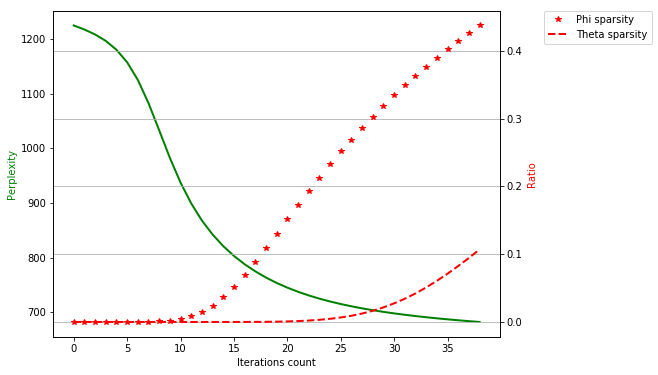

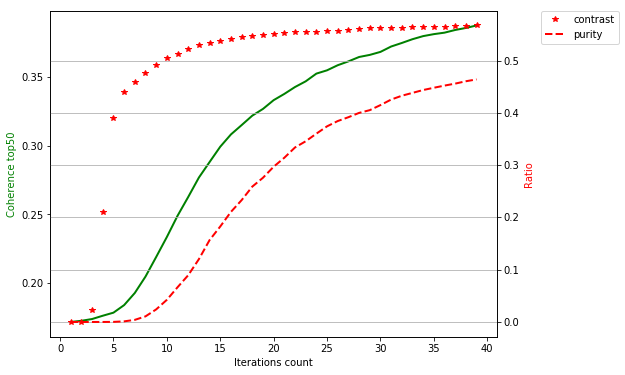

In [378]:
plot(model)

In [379]:
%timeit model.fit_offline(batch_vectorizer=bv, num_collection_passes=25)

1 loop, best of 3: 43.3 s per loop


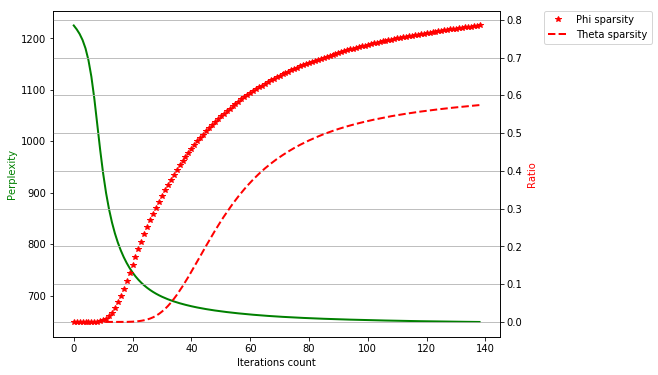

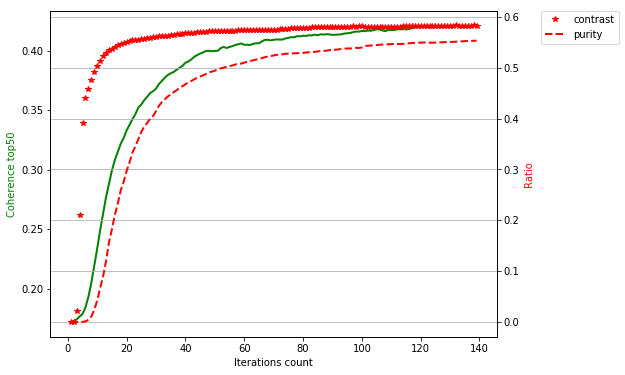

In [380]:
plot(model)

In [381]:
printTopics(model, topics_domain + topics_background)

topic_d0:[70/2675] карта операция обнаруживать совершать производить заблокировать банк то происходить средство транзакция подтверждать сумма не списание втб мой украсть нести оплата блокировать проводить магазин выписка деньги система платеж находиться покупка интернет счет отклонять действие служба это блокировка денежный ситуация проведение безопасность случай факт данный же попытка причина проводиться подтверждение хранить весь тот расплачиваться этот блокироваться мошенник защищать момент уведомление правило клиент руб отказывать совершение банковский так расследование отказ мошенничество мошеннический который
topic_d1:[70/2911] пытаться банкомат принимать деньги не карта стоять вносить зачислять вернуть полагать купюра день втб забирать вставлять претензия происходить съедать рассматривать находиться внесение рубль зафиксировать сумма ул наличный обращение пересчитывать ситуация отделение инкассация средство экран номер проблема адрес же сообщение располагать исчезать г операция 

После того как модель сошлась, потребуем от модели различность предметных тем. Для этого добавим декоррелирующий регуляризатор. Более того добавим регуляризатор сглаживания фоновых тем.

[Описание регуляризаторов](https://bigartm.readthedocs.io/en/stable/api_references/python_interface/regularizers.html)

In [382]:
model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SmoothPhi', tau=0.02, topic_names=topics_background))
model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SmoothTheta', tau=0.02, topic_names=topics_background))
model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=5000000, topic_names=topics_domain))

In [383]:
model.fit_offline(batch_vectorizer=bv, num_collection_passes=20)

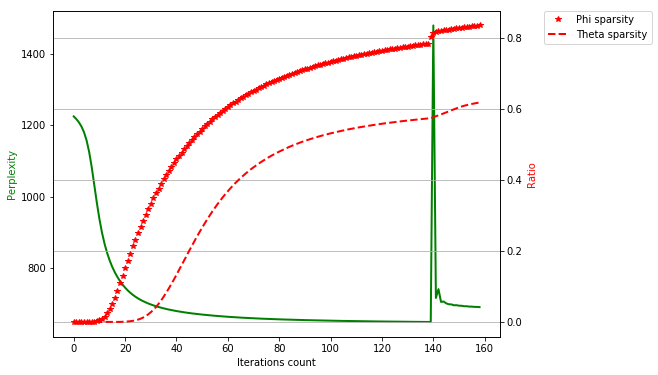

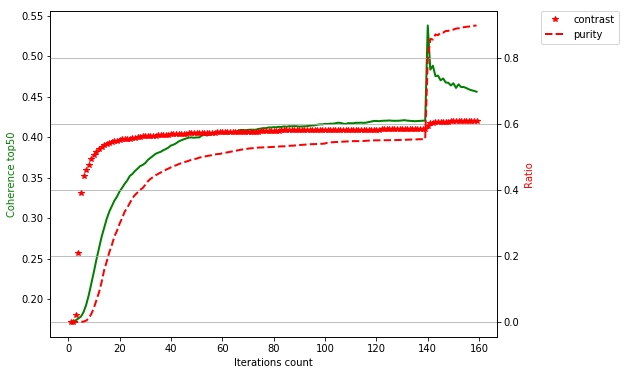

In [384]:
plot(model)

Матрицы $\Phi$ и $\Theta$ стали более разреженными.

In [386]:
Phi = model.get_phi()
printTopics(model, topics_domain + topics_background)

topic_d0:[70/2172] обнаруживать производить совершать списание транзакция нести блокировать выписка украсть магазин блокировка отклонять расплачиваться покупка безопасность проведение хранить мошенник защищать блокироваться совершение мошенничество расследование мошеннический товар возможный обеспечивать совершаться списание_средство операция_совершать кошелек подозревать пропадать опротестование платежный опасаться похищать доказывать отель возмещать полиция известный обработка разблокироваться ответственность оспаривать спорный терминал кража выполняться операция_проводить ночь заблокировать_карта несанкционированный лишать вероятность подтверждаться защита операция_совершение опротестовывать совершенный просматривать сохранять спать возвращение оспаривание авторизация сохранность обкрадывать воровать
topic_d1:[70/2502] банкомат пытаться купюра вставлять наличный съедать зафиксировать исчезать пересчитывать чек экран инкассация располагать надпись вкладывать выплюнуть петербург изыма

Посмотрим на вклад тем в оценку отзывов. Видим, что некоторые темы хорошо скорелированы с оценками пользователей.

Далее, направим усилия на то чтобы вытянуть тональность в отдельные темы.

In [434]:
theta = model.get_theta()
theta = theta.transpose()[topics_domain]
theta.index = map(int, theta.index)

In [435]:
theta = theta.join(replies.mark)

In [436]:
topic_influence = theta.groupby("mark").sum()

In [437]:
topic_influence

,topic_d0,topic_d1,topic_d2,topic_d3,topic_d4,topic_d5,topic_d6,topic_d7,topic_d8,topic_d9,...,topic_d40,topic_d41,topic_d42,topic_d43,topic_d44,topic_d45,topic_d46,topic_d47,topic_d48,topic_d49
mark,,,,,,,,,,,,,,,,,,,,,
-1,104.792854,90.508781,102.942337,74.079788,133.327545,70.386284,77.356369,90.125519,52.105095,62.785557,...,89.507111,78.081833,109.096947,56.703003,74.382851,93.884407,57.471611,58.815884,66.859497,67.505600
1,60.028042,101.797127,112.441513,57.916603,106.783958,54.789444,72.806625,98.826286,48.823341,83.616600,...,74.490341,74.958908,125.629036,64.951668,82.973053,85.309860,64.709541,69.152992,76.282799,64.771034
2,14.653716,30.596909,23.655397,14.650304,19.265179,15.759976,21.860901,27.563368,13.221125,22.859106,...,20.406776,19.960073,31.036324,21.085936,23.938013,18.864777,17.876829,18.838566,22.390270,14.542740
3,7.832756,15.092886,10.423830,7.585405,8.799755,7.118701,13.028861,12.028590,7.119749,9.779010,...,9.924102,12.516489,15.079946,13.219637,11.799343,8.423288,9.207798,9.200191,11.021220,8.217016
4,1.988976,5.645432,2.644984,1.431486,1.220595,2.051446,6.081052,2.778553,2.520660,2.661467,...,1.938894,5.277318,3.980457,6.335550,3.239252,2.280292,2.810806,2.479051,3.069079,2.665340
5,10.715708,11.693943,9.083199,13.115778,7.778440,29.394993,41.155403,14.048961,21.237661,16.596117,...,40.070194,43.940979,28.897078,57.976570,15.315880,11.467977,21.089128,14.236304,17.447666,24.704411


In [439]:
norm = topic_influence.sum(axis=1)

In [440]:
topic_influence = topic_influence.divide(norm, axis=0)

In [441]:
topic_influence

,topic_d0,topic_d1,topic_d2,topic_d3,topic_d4,topic_d5,topic_d6,topic_d7,topic_d8,topic_d9,...,topic_d40,topic_d41,topic_d42,topic_d43,topic_d44,topic_d45,topic_d46,topic_d47,topic_d48,topic_d49
mark,,,,,,,,,,,,,,,,,,,,,
-1,0.026470,0.022862,0.026002,0.018712,0.033677,0.017779,0.019540,0.022765,0.013161,0.015859,...,0.022609,0.019723,0.027557,0.014323,0.018788,0.023714,0.014517,0.014856,0.016888,0.017051
1,0.014506,0.024600,0.027172,0.013996,0.025805,0.013240,0.017594,0.023882,0.011799,0.020207,...,0.018001,0.018114,0.030359,0.015696,0.020051,0.020616,0.015638,0.016711,0.018434,0.015652
2,0.013095,0.027342,0.021139,0.013092,0.017216,0.014083,0.019535,0.024631,0.011815,0.020427,...,0.018236,0.017837,0.027735,0.018843,0.021392,0.016858,0.015975,0.016835,0.020008,0.012996
3,0.013817,0.026623,0.018387,0.013380,0.015522,0.012557,0.022982,0.021218,0.012559,0.017250,...,0.017506,0.022078,0.026600,0.023319,0.020813,0.014858,0.016242,0.016229,0.019441,0.014494
4,0.010766,0.030559,0.014317,0.007749,0.006607,0.011105,0.032917,0.015040,0.013644,0.014407,...,0.010495,0.028566,0.021546,0.034295,0.017534,0.012343,0.015215,0.013419,0.016613,0.014428
5,0.006487,0.007080,0.005499,0.007940,0.004709,0.017796,0.024915,0.008505,0.012857,0.010047,...,0.024258,0.026602,0.017494,0.035099,0.009272,0.006943,0.012767,0.008619,0.010563,0.014956


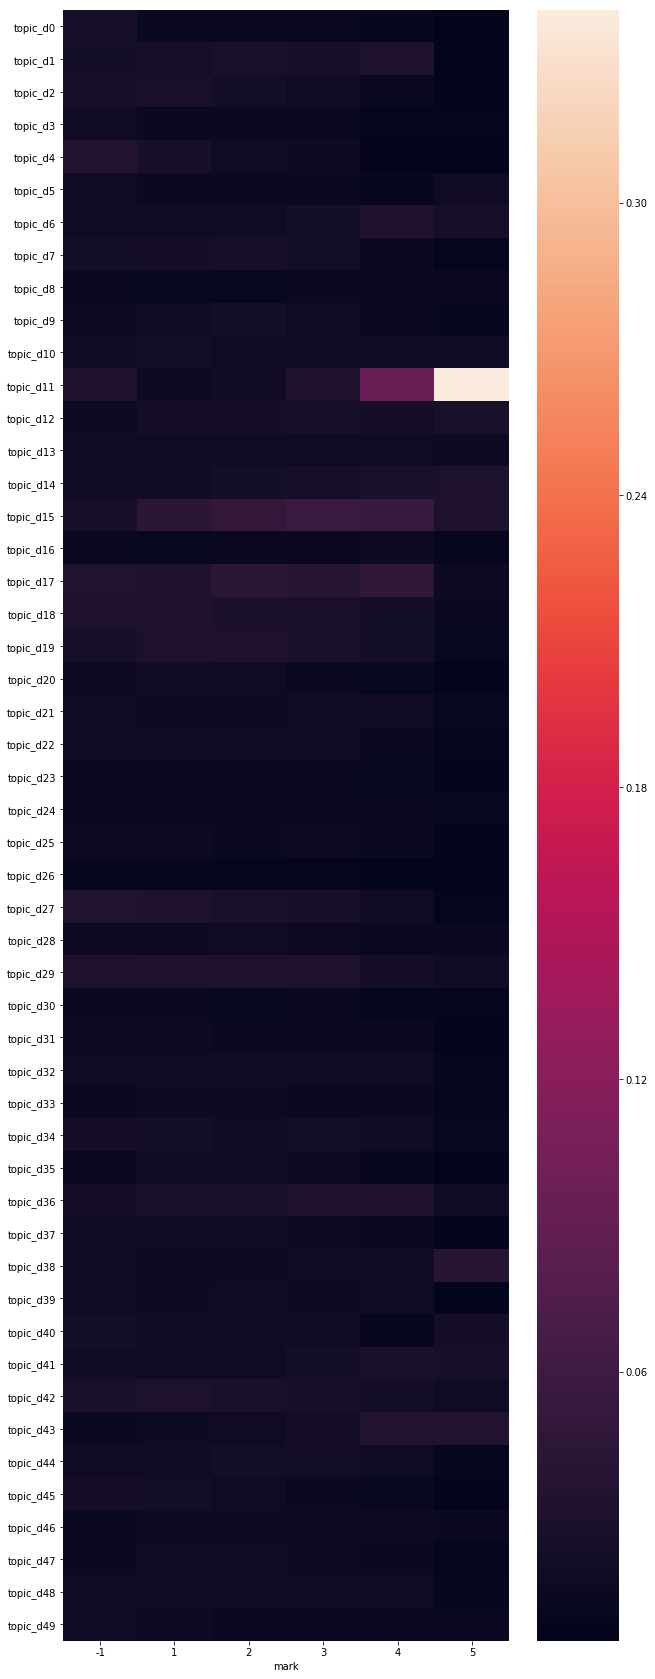

In [442]:
plt.figure(figsize=(10, 30))
heatmap(topic_influence.transpose())

## Добавим словарь тональностей

Воспользуемся общедоступным словарем тональностей [LINES CROWD](http://linis-crowd.org)

Каждое слово в словаре имеет несколько оценок тональности, выражаемых целыми числами от -2 до 2.

Сделаем лемматизацию словаря для того чтобы множество его слов солгасовывалось со словарем тематической модели.

In [445]:
sentiment = pd.read_excel(FOLDER_DATA + "collection (docs&words)_2016_all_labels/full word_rating_after_coding.xlsx", 
                          header=None)
mystem = Mystem()
sentiment[0] = sentiment[0].apply(lambda word: lemmatize(word, mystem)[0])
sentiment.head(10)

,0,1
0,абажур,0
1,абажур,0
2,абажур,-1
3,абориген,-1
4,абориген,-1
5,абориген,0
6,аборт,-2
7,аборт,0
8,аборт,-1
9,аборт,0


In [446]:
sentiment = sentiment.groupby(0).mean()
sentiment.columns = ["value"]
sentiment.value /= 2

Для каждого слова из словаря усредним и отнормируем его оценки тональности.

In [448]:
sentiment.head()

,value
0,
абажур,-0.166667
абориген,-0.333333
аборт,-0.375000
абортивный,-0.125000
абсолютный,0.000000


Отберем тональные слова, встречающиеся в словаре тематической модели.

In [449]:
indexes = set(sentiment.index) & vocab
sentiment = sentiment.loc[indexes]
positive = set(sentiment[sentiment.value > 0].index)
negative = set(sentiment[sentiment.value < 0].index)
sentiment_dict = positive | negative
print "Всего тональных слов {}, из них положительной тональности - {}, \
отрицательной - {}".format(sum(sentiment.value != 0), len(positive), len(negative))

Всего тональных слов 1908, из них положительной тональности - 680, отрицательной - 1228


In [451]:
len(set(sentiment.index))

3529

In [454]:
len(vocab)

11319

### Разделим словарь на две части: тональные и не тональные слова.

In [453]:
bv.dictionary.save_text(FOLDER_DATA + "all.txt")

Составим тональный словарь. Тональным словам зададим вес согласно словарю, остальным словам зададим вес равный нулю.

In [455]:
ethnic_dict_name = 'sentiment'

num_tokens = 0

dictionary_data = artm.messages.DictionaryData()
with codecs.open(FOLDER_DATA + "all.txt", 'r', 'utf-8') as fin:
    dictionary_data.name = "sentiment"
    fin.next()  # skip comment line
    fin.next()

    for line in fin:
        num_tokens += 1
        line_list = line.split(' ')
        
        token = line_list[0][0: -1]
        class_id = line_list[1][0: -1]
        
        dictionary_data.token.append(token)
        dictionary_data.class_id.append(class_id)
        
        if token in sentiment_dict:
            dictionary_data.token_value.append(sentiment.loc[token].value)  # default value for all modalities
        else:
            dictionary_data.token_value.append(0.0)
        
        dictionary_data.token_tf.append(float(line_list[3][0: -1]))
        dictionary_data.token_df.append(float(line_list[4][0: -1]))
        
        
dictionary_sentiment = artm.Dictionary()
dictionary_sentiment.create(dictionary_data)

dictionary_sentiment.save(dictionary_path=FOLDER_DATA + ethnic_dict_name + ".dict")

dictionary_sentiment.save_text(dictionary_path=FOLDER_DATA + ethnic_dict_name + ".txt")

# os.remove(os.path.join(batches_folder, '{}.txt'.format(dict_name)))

print 'Number of tokens in dictionary: {}'.format(num_tokens)

Number of tokens in dictionary: 11913


Составим словарь с нетональными словами. Тональным словам зададим вес равный нулю, у остальных слов не будем изменять вес.

In [456]:
ethnic_dict_name = 'non_sentiment'

num_tokens = 0

dictionary_data = artm.messages.DictionaryData()
with codecs.open(FOLDER_DATA + "all.txt", 'r', 'utf-8') as fin:
    dictionary_data.name = "sentiment"
    fin.next()  # skip comment line
    fin.next()

    for line in fin:
        num_tokens += 1
        line_list = line.split(' ')
        
        token = line_list[0][0: -1]
        class_id = line_list[1][0: -1]
        
        dictionary_data.token.append(token)
        dictionary_data.class_id.append(class_id)
        
        if token in sentiment_dict:
            dictionary_data.token_value.append(abs(sentiment.loc[token].value))  # default value for all modalities
        else:
            dictionary_data.token_value.append(0.0)
        
        dictionary_data.token_tf.append(float(line_list[3][0: -1]))
        dictionary_data.token_df.append(float(line_list[4][0: -1]))
        
        
dictionary_non_sentiment = artm.Dictionary()
dictionary_non_sentiment.create(dictionary_data)

dictionary_non_sentiment.save(dictionary_path=FOLDER_DATA + ethnic_dict_name + ".dict")

dictionary_non_sentiment.save_text(dictionary_path=FOLDER_DATA + ethnic_dict_name + ".txt")

# os.remove(os.path.join(batches_folder, '{}.txt'.format(dict_name)))

print 'Number of tokens in dictionary: {}'.format(num_tokens)

Number of tokens in dictionary: 11913


In [457]:
createTopics(domain_n=50, background_n=5, sentiment=True)

In [458]:
model_sentiment = artm.ARTM(topic_names=topics_sentiment + topics_domain + topics_background, dictionary=bv.dictionary,
                  theta_columns_naming="title",
                  num_document_passes=1, cache_theta=True,reuse_theta=True)

In [460]:
add_scores(model_sentiment)

Потребуем от модели, чтобы тональные слова собрались в двух темах. Для этого будем сглаживать тональные темы по тональному словарю и разреживать предметные по словарю нетональных слов. 


In [461]:
model_sentiment.regularizers.add(artm.SmoothSparsePhiRegularizer(name="sentiment_positive",
                                                                 dictionary=dictionary_sentiment,
                                                                 topic_names=topics_sentiment[0], 
                                                                  tau=1000))
model_sentiment.regularizers.add(artm.SmoothSparsePhiRegularizer(name="sentiment_negative",
                                                                 dictionary=dictionary_sentiment,
                                                                   topic_names=topics_sentiment[1], 
                                                                   tau=-1000))
model_sentiment.regularizers.add(artm.SmoothSparsePhiRegularizer(name="non_sentiment",
                                                                 dictionary=dictionary_non_sentiment,
                                                                topic_names=topics_domain + topics_background,
                                                                tau=-10000))

In [462]:
model_sentiment.fit_offline(batch_vectorizer=bv, num_collection_passes=40)

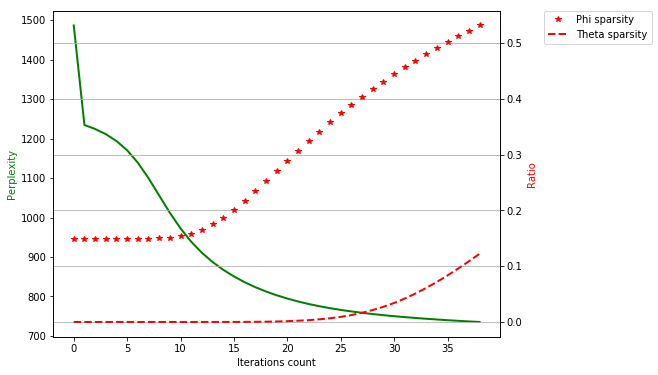

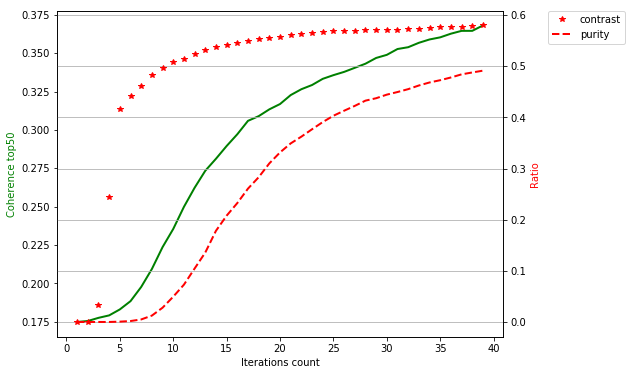

In [463]:
plot(model_sentiment)

In [464]:
model_sentiment.fit_offline(batch_vectorizer=bv, num_collection_passes=100)

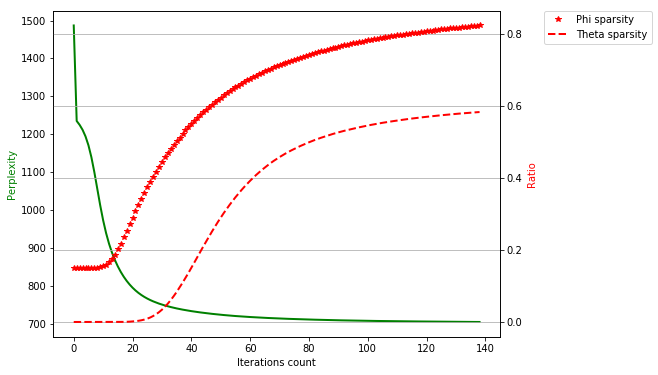

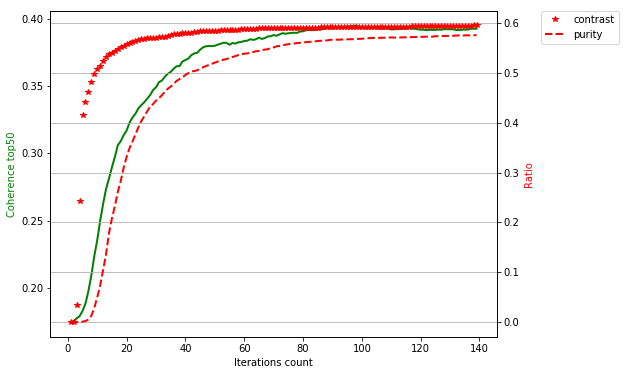

In [465]:
plot(model_sentiment)

Посмторим на топ-токены, тональные слова собрались в первых двух темах.

In [467]:
Phi = model_sentiment.get_phi()
printTopics(model_sentiment, topics_sentiment + topics_domain)

topic_pos:[70/650] сотрудник смочь нужный указывать отказываться одобрять писать пользоваться пытаться много оставлять вернуть помогать страховка проводить срок новый возможность спасибо подписывать надеяться заявлять занимать добрый хороший наш касса встречать поддержка понравиться всегда рекомендовать довольный решаться искать подождать покупка интересный нравиться впечатление помощь возврат исправлять сделка открытие удобный желать важный приятный доход внимание интересовать уважение разный извиняться вежливый стараться положительный захотеть надежда согласный здравствовать благодарность любить увеличивать правда радовать муж бонус верить
topic_neg:[70/1135] заявление проблема списывать выясняться начинаться претензия разбираться отказ сидеть забирать никакой передавать ошибка потратить лицо отдавать забывать заплатить попытка продолжать результат конец выплачивать долг нарушать привилегия жить очередной заставлять руководитель жалоба допускать отсутствовать записывать обманывать по

In [468]:
model_sentiment.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SmoothPhi', tau=0.02, topic_names=topics_background))
model_sentiment.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SmoothTheta', tau=0.02, topic_names=topics_background))
model_sentiment.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorDomain',
                                                       tau=5000000, topic_names=topics_domain))
model_sentiment.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorSentiment',
                                                       tau=5000, topic_names=topics_sentiment))

In [469]:
model_sentiment.fit_offline(batch_vectorizer=bv, num_collection_passes=20)

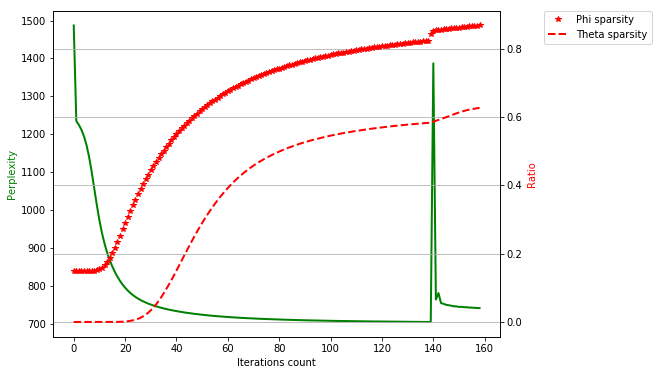

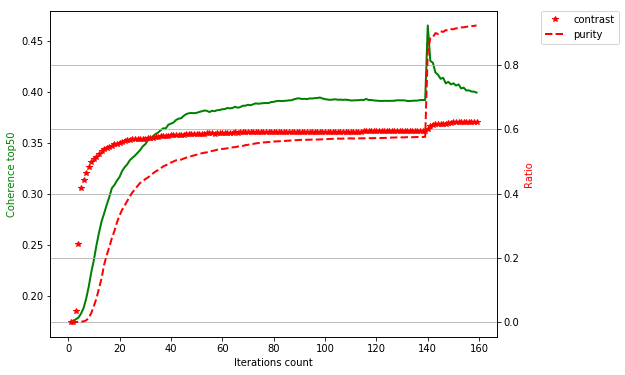

In [470]:
plot(model_sentiment)

In [472]:
Phi = model_sentiment.get_phi()
printTopics(model_sentiment,topics_sentiment + topics_domain)

topic_pos:[70/650] сотрудник смочь нужный указывать отказываться одобрять писать пользоваться пытаться много оставлять вернуть помогать страховка проводить срок новый возможность спасибо подписывать надеяться заявлять занимать добрый хороший наш касса встречать поддержка понравиться всегда рекомендовать довольный решаться искать подождать покупка интересный нравиться впечатление помощь возврат исправлять сделка открытие удобный желать важный приятный доход внимание интересовать уважение разный извиняться вежливый стараться положительный захотеть надежда согласный здравствовать благодарность любить увеличивать правда радовать муж бонус верить
topic_neg:[70/1135] заявление проблема списывать выясняться начинаться претензия разбираться отказ сидеть забирать никакой передавать ошибка потратить лицо отдавать забывать заплатить попытка продолжать результат конец выплачивать долг нарушать привилегия жить очередной заставлять руководитель жалоба допускать отсутствовать записывать обманывать по

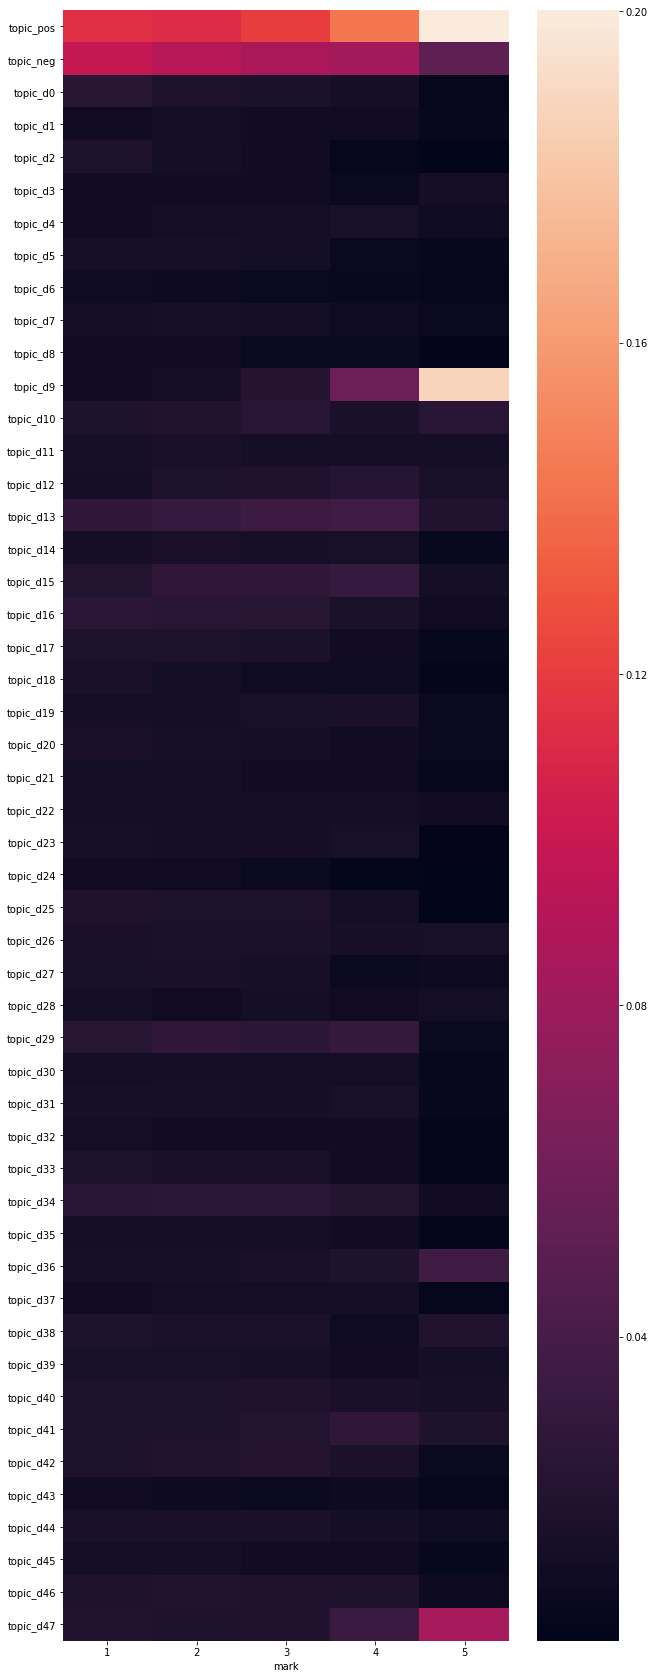

In [473]:
theta = model_sentiment.get_theta()
theta = theta.transpose()[topics_sentiment + topics_domain]
theta.index = map(int, theta.index)
theta = theta.join(replies.mark)
theta = theta[theta.mark != -1]
topic_influence = theta.groupby("mark").sum()
norm = topic_influence.sum(axis=1)
topic_influence = topic_influence.divide(norm, axis=0)
plt.figure(figsize=(10, 30))
heatmap(topic_influence.transpose())

Вытянем матрицу $\Theta$ из модели. Проигнорируем фоновые темы и перенормируем матрицу.

In [474]:
theta = model_sentiment.get_theta().loc[topics_sentiment + topics_domain]
theta = theta.divide(theta.sum(axis=0), axis=1)

Оценим тональности $s$ предметной темы $t$ для банка $b$. 

$p(t_s | b, t) =   \frac{1}{|D|}\sum_{d \in D} p(t = t_s | b, d) * p(t | b, d) [p(t = t_s | b, d) > 0.1, p(t | b, d) > 0.1]$,

где $D$ --- множество отзывов.

P.S.
- тут явные проблемы с обозначениями/вероятностным пространством. Оставим эту формулу в качестве эвристики для лучшего понимания.
- можно код переписать слишком неоптимально.

In [ ]:
banks = {'vtb24': 0}
bank_topic_sentiment = np.zeros((len(banks), len(topics_domain), 3))
for index, row in theta.transpose().iterrows():
    positive = row.topic_pos
    negative = row.topic_neg
    if positive > 0.2 or negative > 0.2:
        selected = row[topics_domain][row > 0.1]
        if len(selected) > 0:
            for topic in selected.index:
                bank = banks[replies.loc[int(index)].bank]
                topic_influence = selected[topic]
                topic = int(topic.split("_")[1][1:])
                sentiment = np.argmax(row[topics_sentiment])
                if sentiment == "topic_pos":
                    sentiment = 0
                    sentiment_value = positive
                else:
                    sentiment = 1
                    sentiment_value = negative
                bank_topic_sentiment[bank, topic, sentiment] += sentiment_value * topic_influence
                bank_topic_sentiment[bank, topic, 2] += 1

In [486]:
bank_topic = np.zeros((len(banks), len(topics_domain)))
not_null_columns = []
for i, bank in enumerate(bank_topic_sentiment):
    not_null = False
    for j, topic in enumerate(bank):
        if topic[2] > 10:
            bank_topic[i, j] = float(topic[0]) / (topic[0] + topic[1])
            not_null = True
        else:
            bank_topic[i, j] = float("nan")
    not_null_columns.append(not_null)
bank_topic = bank_topic[not_null_columns]

In [487]:
# Phi = model.get_phi()
def printTopics(topics, num=70, print_file=False):
    zeros = 0
    string_to_print = ""
    for i, topic in enumerate(topics):
        topicSeries = Phi[topic].sort_values(ascending=False)[:num]
        indexes = topicSeries > 0
        result = topicSeries[indexes].index
        string_to_print += topic + ":[{}/{}] ".format(len(result), sum(Phi[topic] > 0)) + " ".join(result) + "\n"
        zeros += len(result) == 0
    print string_to_print
    if print_file:
        with codecs.open(FOLDER_DATA + 'topics_d{}_b{}.txt'.format(DOMAIN_N, BACKGROUND_N), 'w', 'utf8') as outputFile:
            print >> outputFile, string_to_print

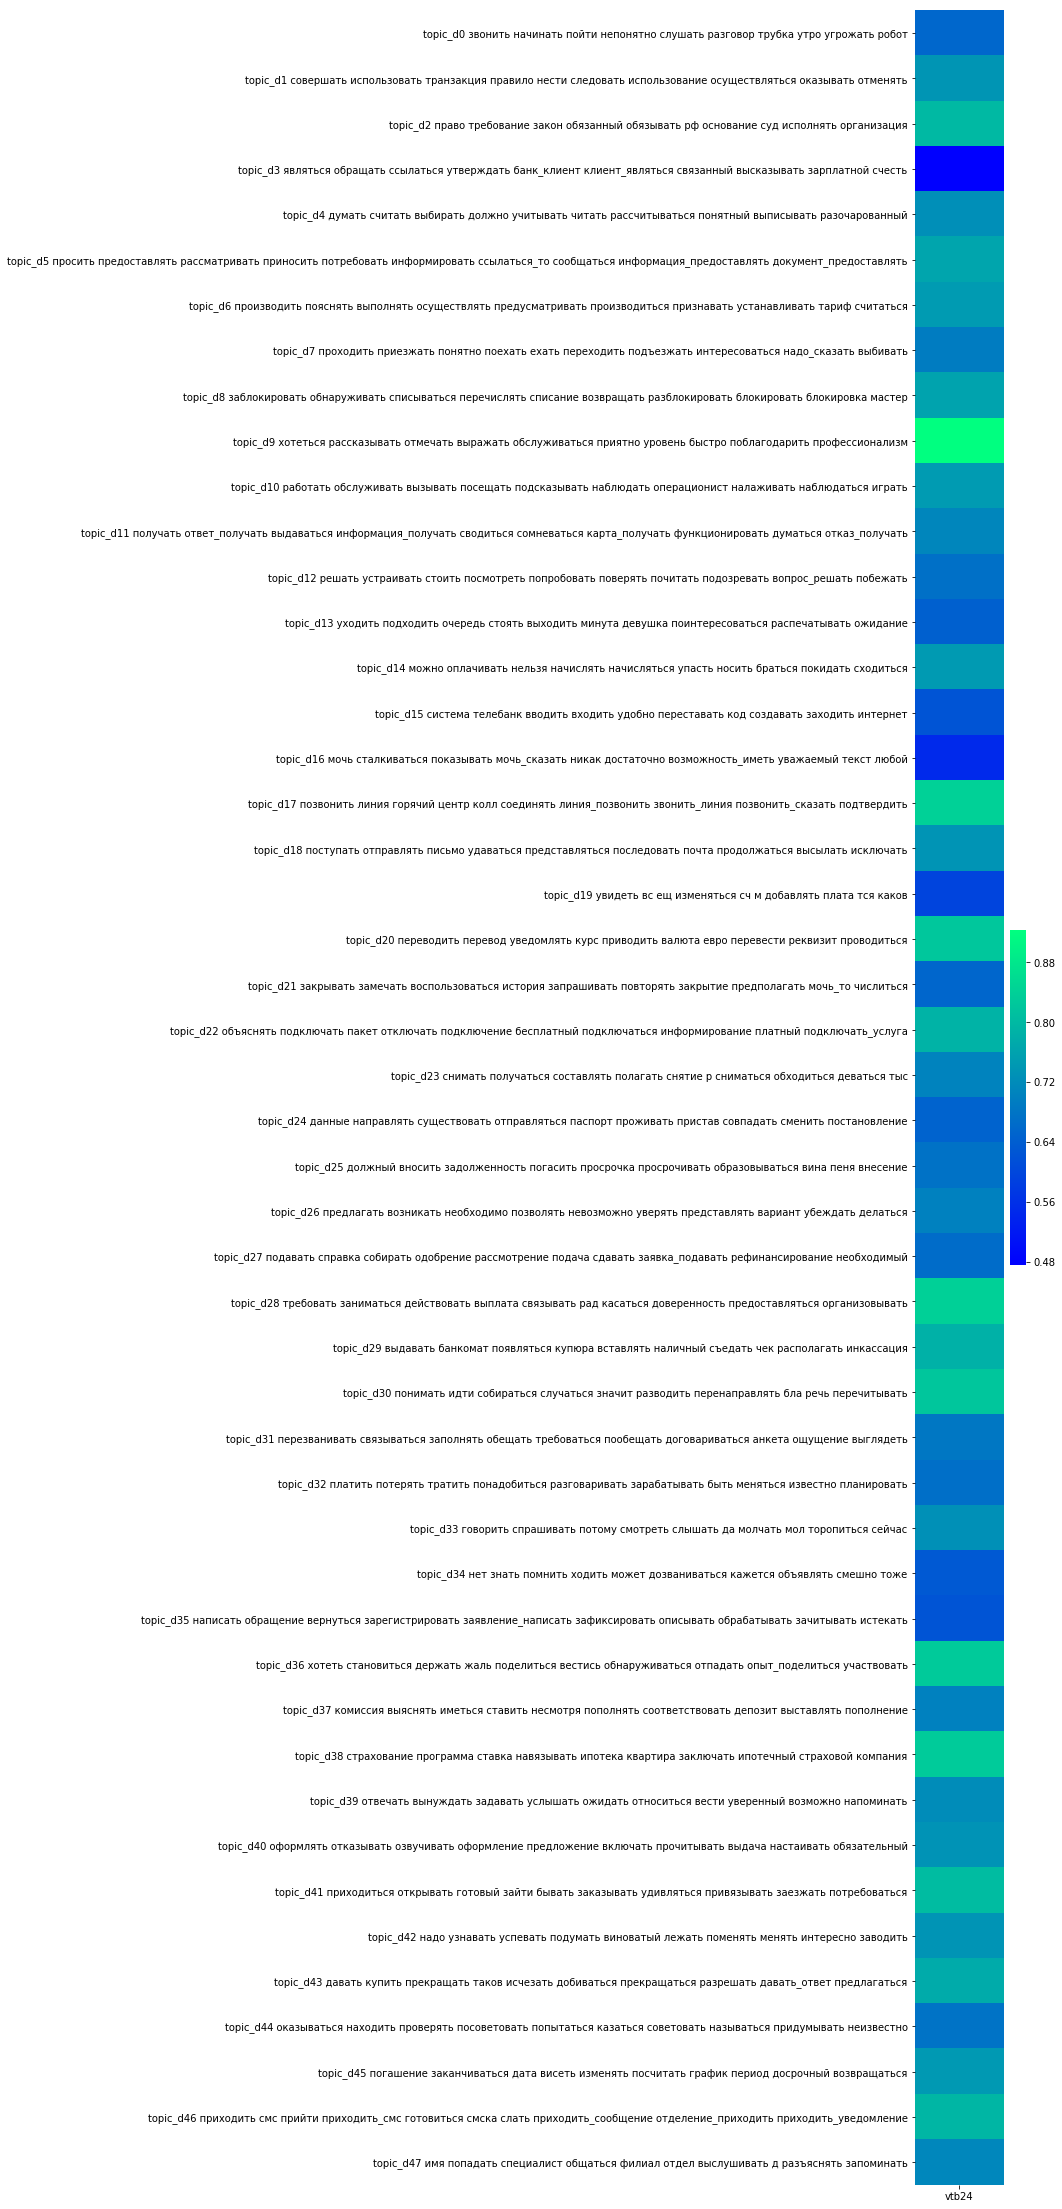

In [532]:
plt.figure(figsize=(2, 40))
data_bank = pd.DataFrame(bank_topic.transpose())
data_bank.columns = [key for key, value in sorted(banks.items(), key=lambda x:x[1]) if not_null_columns[value]]
description = []
Phi = model_sentiment.get_phi()
for i, topic in enumerate(topics_domain):
        topicSeries = Phi[topic].sort_values(ascending=False)[:10]
        indexes = topicSeries > 0
        result = topicSeries[indexes].index
        description.append(topic + " " + " ".join(result))
data_bank.index = description
heatmap(data_bank , cmap="winter")
plt.savefig("banks_sentiment_replies.png")

In [489]:
printTopics(topics=topics_sentiment + topics_domain, print_file=True)

topic_pos:[70/650] сотрудник смочь нужный указывать отказываться одобрять писать пользоваться пытаться много оставлять вернуть помогать страховка проводить срок новый возможность спасибо подписывать надеяться заявлять занимать добрый хороший наш касса встречать поддержка понравиться всегда рекомендовать довольный решаться искать подождать покупка интересный нравиться впечатление помощь возврат исправлять сделка открытие удобный желать важный приятный доход внимание интересовать уважение разный извиняться вежливый стараться положительный захотеть надежда согласный здравствовать благодарность любить увеличивать правда радовать муж бонус верить
topic_neg:[70/1135] заявление проблема списывать выясняться начинаться претензия разбираться отказ сидеть забирать никакой передавать ошибка потратить лицо отдавать забывать заплатить попытка продолжать результат конец выплачивать долг нарушать привилегия жить очередной заставлять руководитель жалоба допускать отсутствовать записывать обманывать по

## WNTM

In [490]:
PATH_TO_WW_VW = FOLDER_DATA + 'ww_vw.txt'
FOLDER_BATCHES_WW = FOLDER_DATA + 'batches_wntm/'

Подготовим батчи

In [500]:
bv_ww = artm.BatchVectorizer(data_path=PATH_TO_WW_VW, data_format='vowpal_wabbit',
                             target_folder=FOLDER_BATCHES_WW)

Добавим метрики качества

In [501]:
createTopics(domain_n=50, background_n=5, sentiment=True)

Инициализируем модель

In [502]:
model_vw = artm.ARTM(topic_names=topics_sentiment + topics_domain + topics_background, dictionary=bv_ww.dictionary,
                  theta_columns_naming="title",
                  num_document_passes=1, cache_theta=True,reuse_theta=True)
add_scores(model_vw)

In [529]:
topics_sentiment

['topic_pos', 'topic_neg']

In [503]:
dictionary_sentiment = artm.Dictionary(dictionary_path=FOLDER_DATA + "sentiment.dict")
dictionary_non_sentiment = artm.Dictionary(dictionary_path=FOLDER_DATA + "non_sentiment.dict")

In [504]:
model_vw.regularizers.add(artm.SmoothSparsePhiRegularizer(name="sentiment_positive",
                                                                 dictionary=dictionary_sentiment,
                                                                 topic_names=topics_sentiment[0], 
                                                                  tau=1000))
model_vw.regularizers.add(artm.SmoothSparsePhiRegularizer(name="sentiment_negative",
                                                                 dictionary=dictionary_sentiment,
                                                                   topic_names=topics_sentiment[1], 
                                                                   tau=-1000))
model_vw.regularizers.add(artm.SmoothSparsePhiRegularizer(name="non_sentiment",
                                                                 dictionary=dictionary_non_sentiment,
                                                                topic_names=topics_domain + topics_background,
                                                                tau=-10000))

In [505]:
model_vw.fit_offline(batch_vectorizer=bv_ww, num_collection_passes=40)

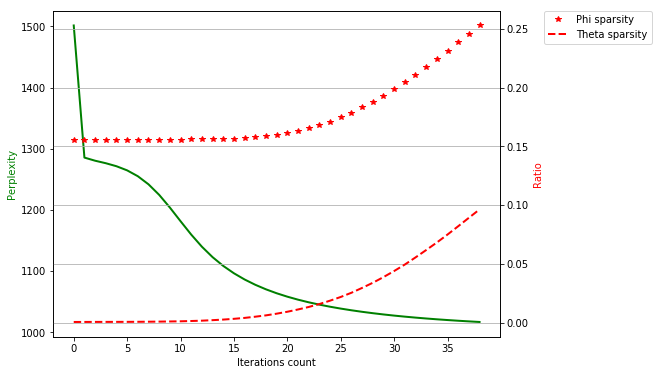

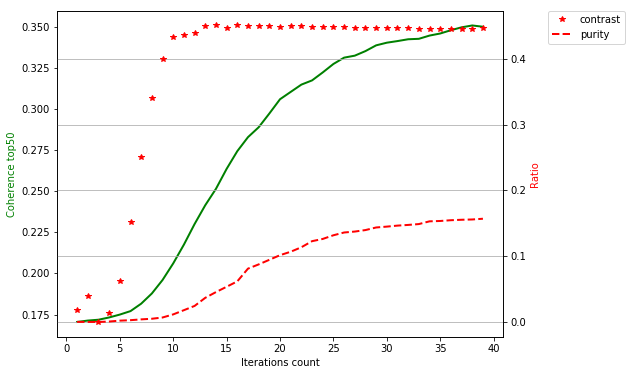

In [497]:
plot(model_vw)

In [498]:
model_vw.fit_offline(batch_vectorizer=bv_ww, num_collection_passes=20)

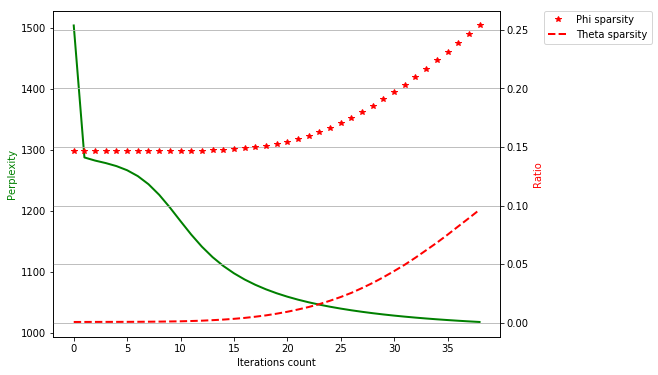

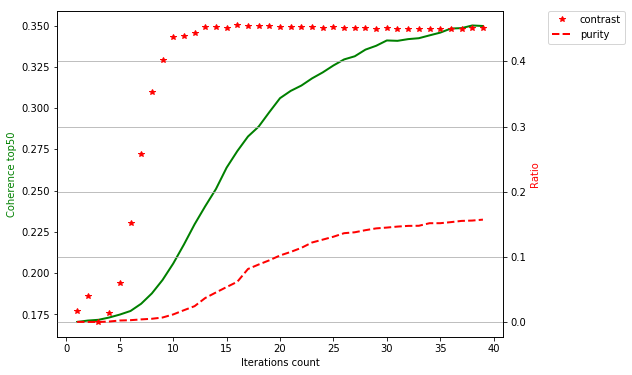

In [507]:
plot(model_vw)

In [508]:
Phi = model_vw.get_phi()
printTopics(topics_sentiment + topics_domain)

topic_pos:[70/10083] сотрудник указывать смочь пользоваться писать отказываться пытаться проблема оставлять вернуть много списывать помогать выясняться срок проводить возможность начинаться одобрять заявлять надеяться передавать подписывать новый занимать забирать отказ страховка никакой заплатить ошибка забывать потратить возврат отдавать долг спасибо хороший нужный жить наш искать выплачивать покупка имя подождать касса открытие результат понравиться поддержка рекомендовать решаться встречать мобильный помощь нравиться россия исправлять впечатление интересный довольный желать стараться посылать интересовать удобный всегда подпись невозможный
topic_neg:[70/8287] претензия разбираться лицо сидеть попытка продолжать конец нарушать штраф руководитель жалоба заставлять подтверждение допускать набирать записывать доказывать отсутствовать ошибаться нарушение украсть повторяться терять очередной пропадать обманывать угроза расплачиваться плакать окно хватить куча старый превышать взыскание и

In [509]:
model_vw.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SmoothPhi', tau=0.02, topic_names=topics_background))
model_vw.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SmoothTheta', tau=0.02, topic_names=topics_background))
model_vw.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorDomain',
                                                       tau=5000000, topic_names=topics_domain))
model_vw.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorSentiment',
                                                       tau=500000, topic_names=topics_sentiment))

In [512]:
model_vw.fit_offline(batch_vectorizer=bv_ww, num_collection_passes=20)

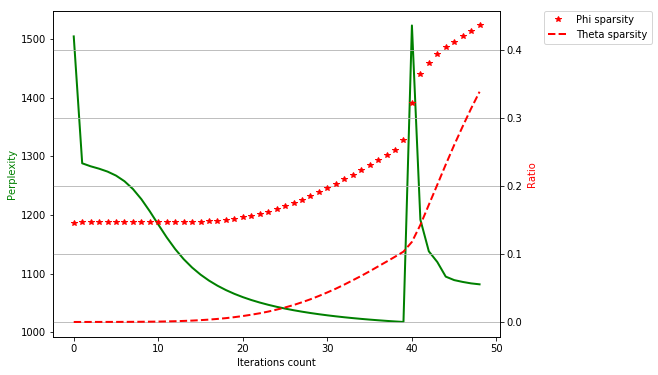

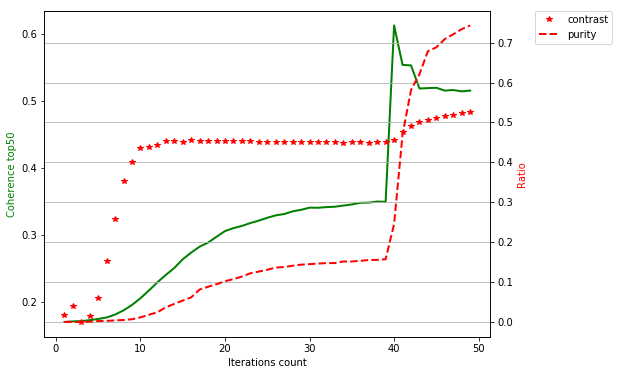

In [511]:
plot(model_vw)

In [545]:
Phi = model_vw.get_phi()
printTopics(topics_sentiment + topics_domain)

topic_pos:[70/6658] имя сотрудник смочь указывать пользоваться писать отказываться пытаться проблема оставлять вернуть много списывать помогать выясняться срок проводить возможность начинаться одобрять заявлять надеяться передавать подписывать новый занимать забирать отказ страховка никакой заплатить ошибка забывать потратить возврат отдавать долг спасибо хороший жить наш искать выплачивать покупка подождать касса открытие результат понравиться поддержка рекомендовать решаться встречать мобильный помощь нравиться россия исправлять впечатление интересный довольный желать стараться посылать интересовать удобный всегда подпись невозможный внимание
topic_neg:[70/1980] претензия разбираться лицо сидеть попытка продолжать конец нарушать штраф руководитель жалоба заставлять подтверждение допускать набирать записывать доказывать отсутствовать ошибаться нарушение украсть повторяться терять очередной пропадать обманывать угроза расплачиваться плакать окно хватить куча старый превышать взыскание 

In [547]:
Phi.shape

(12078, 55)

Мы получили матрицу Words-Topics после моделирования для псевдо-документов. Теперь возьмем наши предложения из отзывов

In [515]:
PATH_TO_WW_SENTENCES = FOLDER_DATA + 'vw_sentences.txt'
FOLDER_BATCHES_SENTENCES = FOLDER_BATCHES + 'sentences/'

In [517]:
num = 10
with codecs.open(PATH_TO_WW_SENTENCES, encoding="utf-8") as input_vw:
    lines = input_vw.read().splitlines()
    lines_n = len(lines)
    part = lines_n / num
    for i in xrange(num):
        with codecs.open(FOLDER_DATA + 'vw_sentences_{}.txt'.format(i), "w", encoding="utf-8") as output_vw:
            print >> output_vw, "\n".join(lines[part * i : part * (i + 1)])

In [519]:
banks = {'vtb24':0}
bank_topic_sentiment = np.zeros((len(banks), len(topics_domain), 3))

In [559]:
for i in xrange(10):
    PATH_TO_WW_SENTENCES = FOLDER_DATA + 'vw_sentences_{}.txt'.format(i)
    FOLDER_BATCHES_SENTENCES = FOLDER_BATCHES + 'sentences_{}/'.format(i)
    bv_sentences = artm.BatchVectorizer(data_path=PATH_TO_WW_SENTENCES, data_format='vowpal_wabbit', batch_size=10000,
                                        target_folder=FOLDER_BATCHES_SENTENCES)
    theta_sentences = model_vw.transform(bv_sentences) #получим матрицу theta для предложений из батча

    #возьмем из неё строки, соответствующие основным и тональным топикам
    theta = theta_sentences.loc[topics_sentiment + topics_domain] 
    theta = theta.divide(theta.sum(axis=0), axis=1)

    for index, row in theta.transpose().iterrows():
        positive = row.topic_pos
        negative = row.topic_neg
        if positive > 0.3 or negative > 0.3:
            selected = row[topics_domain][row > 0.3]
            if len(selected) > 0:
                for topic in selected.index:
                    bank = banks[replies.loc[sentences_replies.loc[int(index)].reply_id].bank]
                    topic_influence = selected[topic]
                    topic = int(topic.split("_")[1][1:])
                    sentiment = np.argmax(row[topics_sentiment])
                    if sentiment == "topic_pos":
                        sentiment = 0
                        sentiment_value = positive
                    else:
                        sentiment = 1
                        sentiment_value = negative
                    bank_topic_sentiment[bank, topic, sentiment] += sentiment_value * topic_influence
                    bank_topic_sentiment[bank, topic, 2] += 1

In [565]:
bank_topic = np.zeros((len(banks), len(topics_domain)))
not_null_columns = []
for i, bank in enumerate(bank_topic_sentiment):
    not_null = False
    for j, topic in enumerate(bank):
        if topic[2] > 10:
            bank_topic[i, j] = float(topic[0]) / (topic[0] + topic[1])
            not_null = True
        else:
            bank_topic[i, j] = float("nan")
    not_null_columns.append(not_null)
bank_topic = bank_topic[not_null_columns]

In [566]:
Phi = model_vw.get_phi()

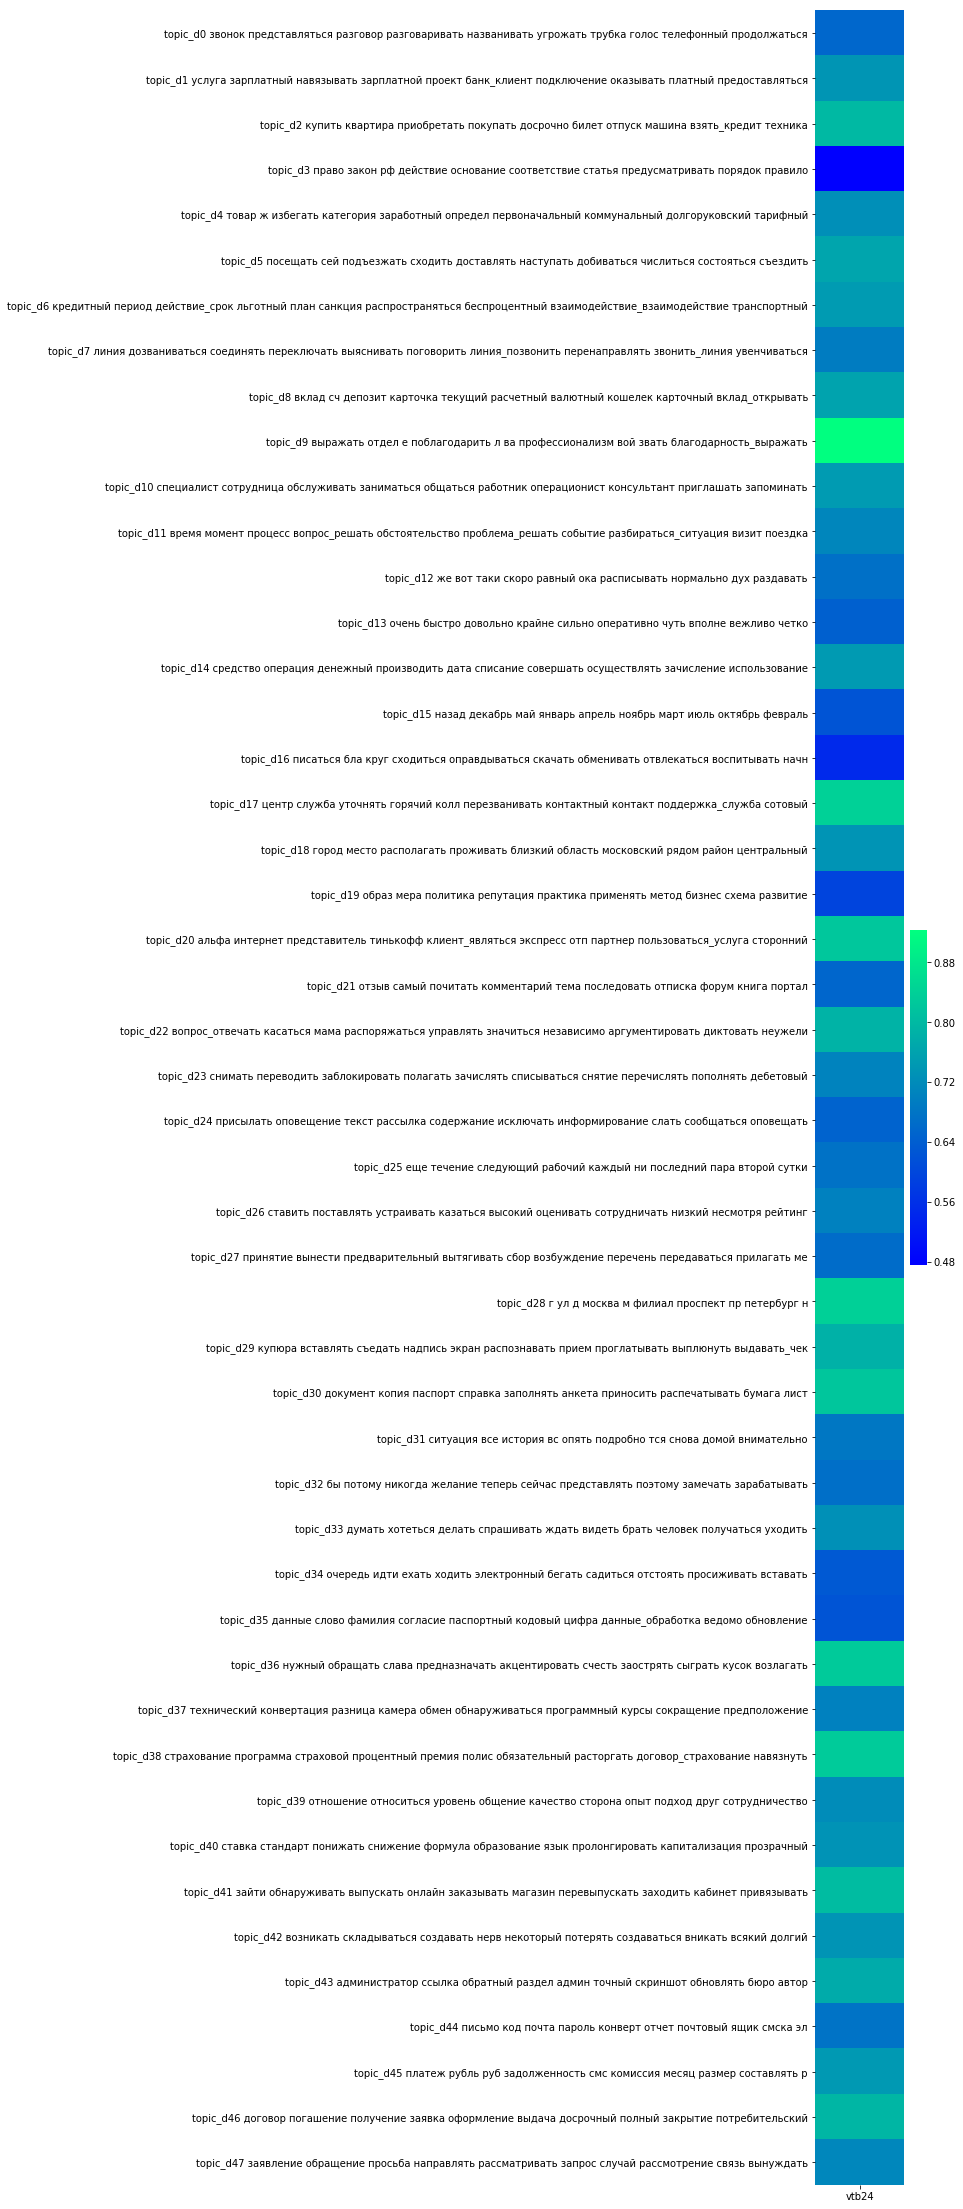

In [568]:
plt.figure(figsize=(2, 40))
data_bank = pd.DataFrame(bank_topic.transpose())
data_bank.columns = [key for key, value in sorted(banks.items(), key=lambda x:x[1]) if not_null_columns[value]]
description = []
Phi = model_vw.get_phi()
for i, topic in enumerate(topics_domain):
        topicSeries = Phi[topic].sort_values(ascending=False)[:10]
        indexes = topicSeries > 0
        result = topicSeries[indexes].index
        description.append(topic + " " + " ".join(result))
data_bank.index = description
heatmap(data_bank , cmap="winter")

### Получим свой словарь тональностей

Попробуем получить свой словарь тональностей. Как и ранее, будем считать что тональность отзыва и его оценка согласованы. Предположим, что словам с отрицательной тональностью соответствуют отзывы с оценками от 1 до 3, с отрицательной тональностью оценки 4 и 5. 

Будем считать, что заданы всего 2 темы. Для каждого документа знаем его тему. Если декоррелировать темы то, как раз и получим тональные слова для каждой из тональностей.

In [569]:
PATH_TO_VW_SENTIMENT_NEW = FOLDER_DATA + 'vw_sentiment.txt'
FOLDER_BATCHES_SENTIMENT_NEW = FOLDER_BATCHES + 'sentiment_new/'

In [570]:
bv_sentiment = artm.BatchVectorizer(data_path=PATH_TO_VW_SENTIMENT_NEW, data_format="vowpal_wabbit",
                                    target_folder=FOLDER_BATCHES_SENTIMENT_NEW, gather_dictionary=True)

Создадим тональные темы и одну фоновую

In [572]:
createTopics(domain_n=0, background_n=1, sentiment=True)

In [573]:
model_sentiment_new = artm.ARTM(topic_names=topics_sentiment + topics_background, dictionary=bv_sentiment.dictionary,
                            theta_columns_naming="title",
                  num_document_passes=1, cache_theta=True, reuse_theta=True)

Зададим веса тональностей для документов

In [574]:
indexes = list(replies[replies.mark != -1].index)
doc_titles = map(str, indexes)
doc_coeff = []
marks = [[-1, 100, 0], [-1, 10, 0],  [-1, 1, 0], [10, -1, 0], [100, -1, 0]]
for index, mark in replies.loc[indexes].mark.iteritems():
    doc_coeff.append(marks[mark - 1])

In [576]:
add_scores(model_sentiment_new)

In [577]:
model_sentiment_new.regularizers.add(artm.SmoothSparseThetaRegularizer(name="SST", tau=1000, doc_titles=doc_titles,
                                                                       doc_topic_coef=doc_coeff))

In [578]:
model_sentiment_new.fit_offline(batch_vectorizer=bv_sentiment, num_collection_passes=20)

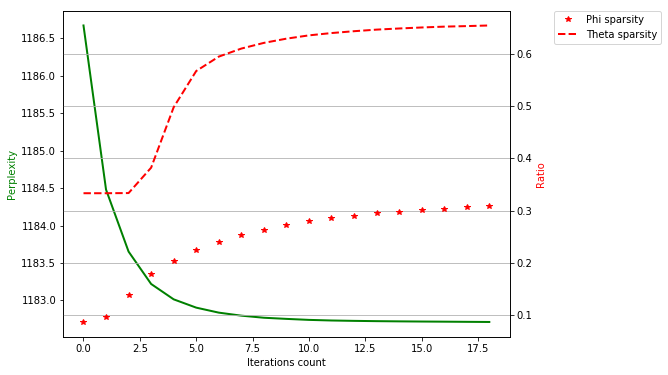

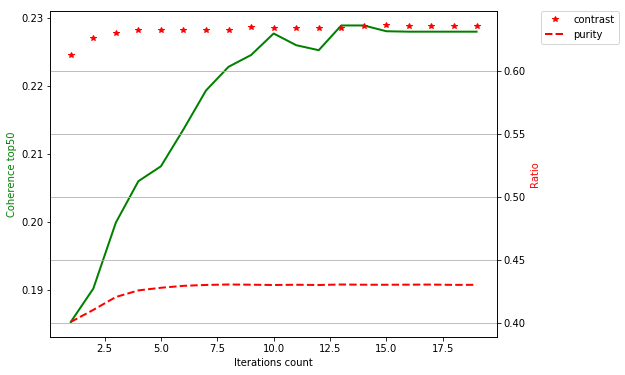

In [579]:
plot(model_sentiment_new)

Декоррелируем тональные темы

In [580]:
model_sentiment_new.regularizers.add(artm.DecorrelatorPhiRegularizer(name="decorrelataion", tau=5e10,
                                                                 topic_names=topics_sentiment))

In [581]:
model_sentiment_new.fit_offline(batch_vectorizer=bv_sentiment, num_collection_passes=10)

Обрежем хвост распределения для темы с негативной тональностью

In [582]:
model_sentiment_new.regularizers.add(artm.SmoothSparsePhiRegularizer("sparsePhi", topic_names=topics_sentiment[0],
                                                                 tau=-1000))

In [588]:
model_sentiment_new.regularizers.add(artm.SmoothSparsePhiRegularizer("sparsePhi", topic_names=topics_sentiment[1],
                                                                 tau=-1000))

AttributeError: Unable to replace existing regularizer.                                  If you really want to do it use overwrite=True argument

In [583]:
model_sentiment_new.fit_offline(batch_vectorizer=bv_sentiment, num_collection_passes=2)

In [587]:
printTopics(topics_sentiment, num=100)

topic_pos:[100/6658] имя сотрудник смочь указывать пользоваться писать отказываться пытаться проблема оставлять вернуть много списывать помогать выясняться срок проводить возможность начинаться одобрять заявлять надеяться передавать подписывать новый занимать забирать отказ страховка никакой заплатить ошибка забывать потратить возврат отдавать долг спасибо хороший жить наш искать выплачивать покупка подождать касса открытие результат понравиться поддержка рекомендовать решаться встречать мобильный помощь нравиться россия исправлять впечатление интересный довольный желать стараться посылать интересовать удобный всегда подпись невозможный внимание здравствовать доход добрый важный извиняться увеличивать согласный разный процедура верить уметь надежда привозить доверять безопасность приятный дом захотеть единственный русский сделка положительный вежливый принадлежать правда маленький радовать обязательство любить компетентный
topic_neg:[100/1980] претензия разбираться лицо сидеть попытка 